In [91]:
import os, sys
import subprocess
import numpy as np
import scipy as sp
import json

from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from preprocess_utilities import *
from data_manager import *
from registration_utilities import *

In [ ]:
stack = "MD"

In [168]:
DataManager.get_image_filepath_v2(stack="DK17", fn='test_img', prep_id="None", version=None, resol='raw')

'/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/DK17/DK17_raw/test_img_raw.tif'

# Volume from Human Annotation Vertices

In [174]:
def get_hand_annotations( stack ):
    if stack=="MD585":
        hand_annotations = load_hdf_v2(ROOT_DIR+'/CSHL_labelings_v3/MD585/MD585_annotation_contours_05312018041032_prep2_corr2.hdf')
    if stack=="MD589":
        hand_annotations = load_hdf_v2(ROOT_DIR+'/CSHL_labelings_v3/MD589/MD589_annotation_contours_05312018031718_prep2_corr1.hdf')
    if stack=="MD594":
        hand_annotations = load_hdf_v2(ROOT_DIR+'/CSHL_labelings_v3/MD594/MD594_annotation_contours_05312018035134_prep2_corr1.hdf')

    return hand_annotations

def get_structure_vertices( stack, target_str ):
    hand_annotations = get_hand_annotations(stack)

    structure_vertices = {}

    for i in range( len(hand_annotations) ):
        curr_structure = hand_annotations['name'][i]
        side = hand_annotations['side'][i]
        section = hand_annotations['section'][i]

        if side=='R' or side=='L':
            curr_structure = curr_structure+'_'+side

        if curr_structure==target_str:
            vertices = hand_annotations['vertices'][i]
            structure_vertices[section] = vertices

    structure_sections = np.sort( structure_vertices.keys() )

    first_section = structure_sections[0]
    last_section = structure_sections[len(structure_sections)-1]
    # Generates a list of all integers from first_section to last_section
    section_list_complete = np.linspace( first_section, last_section, num=(last_section-first_section)+1)
    section_list_complete = [int(i) for i in section_list_complete] # Convert all items to int
    # Find which sections were skipped
    skipped_structure_sections = np.sort( list( set(section_list_complete) - set(structure_sections) ) )

    for skipped_sec in skipped_structure_sections:
        for section_seperation in [-1,-2,-3,-4,-5,-6,-7,-8]:
            try:
                structure_vertices[skipped_sec] = \
                    structure_vertices[ skipped_sec + section_seperation ]
                break
            except Exception as e:
                pass
            
    return structure_vertices, first_section, last_section

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def convert_xy_list_to_x_y( xy_list ):
    x_list = []
    y_list = []
    for x, y in xy_list:
        x_list.append(x)
        y_list.append(y)
    return x_list, y_list

def get_structure_volume( stack, target_str, stack_resolution, plot=False):
    structure_vertices, first_section, last_section = get_structure_vertices( stack=stack, target_str=target_str )

    total_volume = 0

    structure_area_by_slice = []
    for i in np.sort( structure_vertices.keys()):
        x, y = convert_xy_list_to_x_y( structure_vertices[i] )
        area = PolyArea(x,y) * stack_resolution**2
        structure_area_by_slice.append( area )
        total_volume += area * 20
        
    if plot:
        plt.plot( np.sort(structure_vertices.keys()), structure_area_by_slice )
        plt.title( target_str )
        plt.xlabel("Slice Num")
        plt.ylabel("Area (um^2)")
        plt.show()
        
    return total_volume, structure_area_by_slice

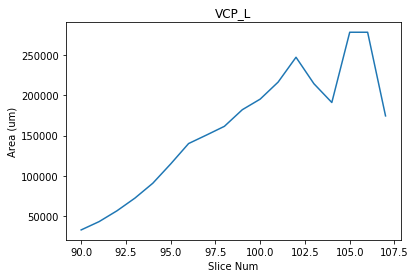

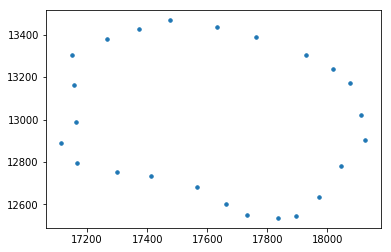

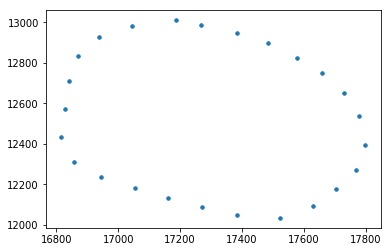

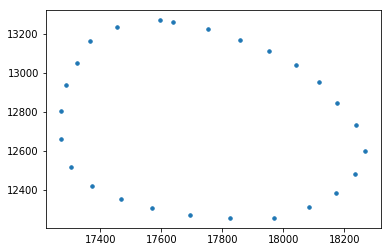

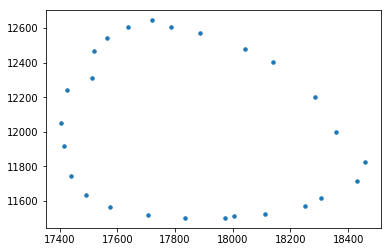

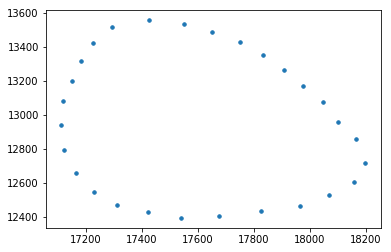

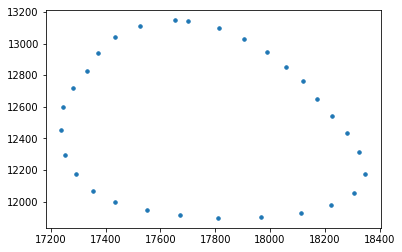

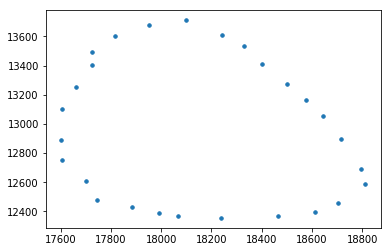

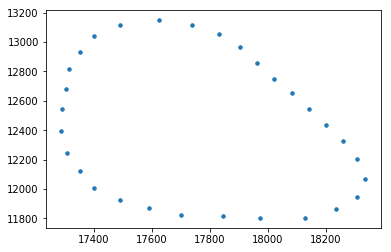

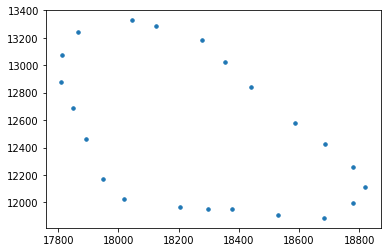

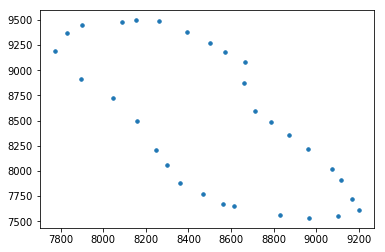

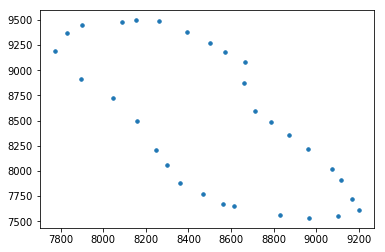

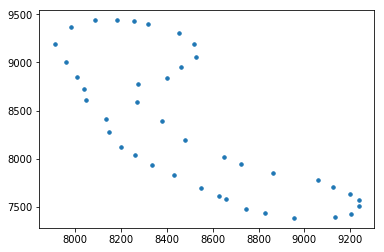

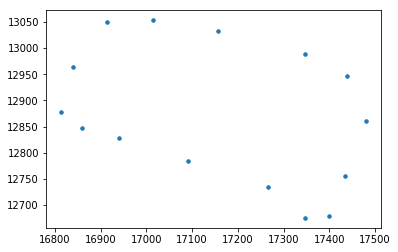

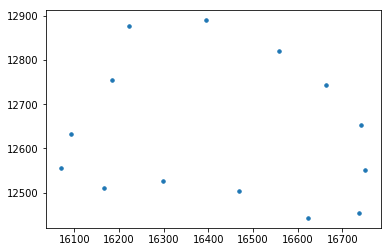

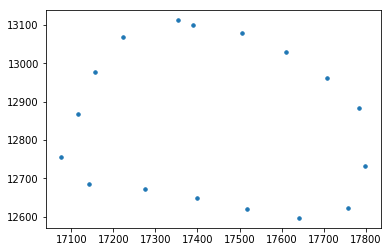

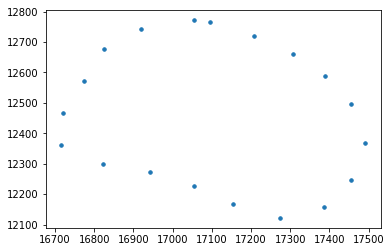

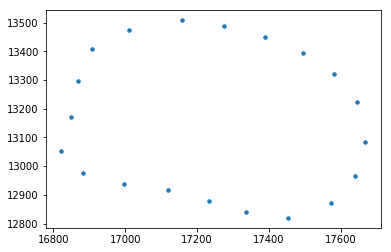

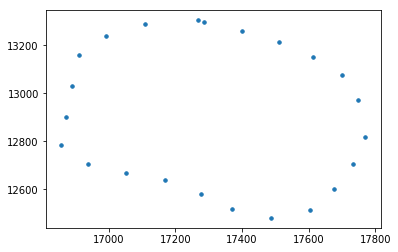

In [154]:
# Analyze the vertices of weird structures (area plots look strange)

for target_str in ['VCP_L']:
    structure_vertices, first_section, last_section = get_structure_vertices( stack=stack, target_str=target_str )
    total_volume, structure_area_by_slice = \
        get_structure_volume( stack=stack, target_str=target_str, stack_resolution=stack_resolution, plot=True)
        
for i in structure_vertices.keys():
    x, y = convert_xy_list_to_x_y( structure_vertices[i] )
    plt.scatter(x,y, s=12)
    plt.show()

In [151]:
first_section

90

In [152]:
last_section

107

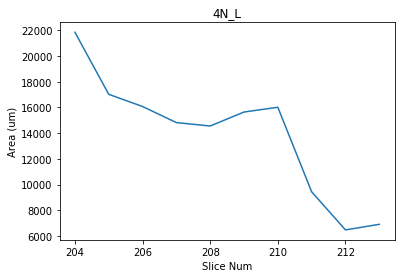

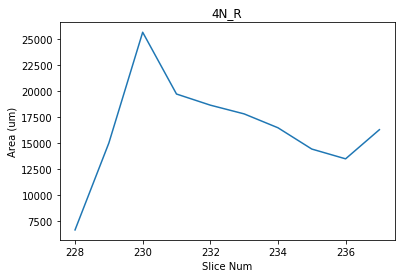

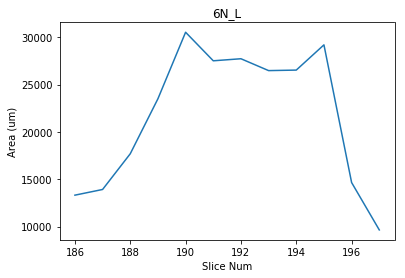

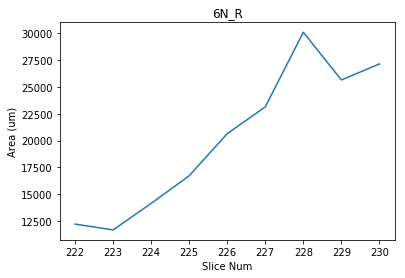

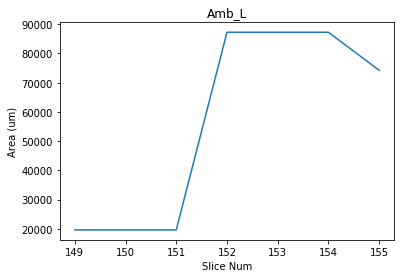

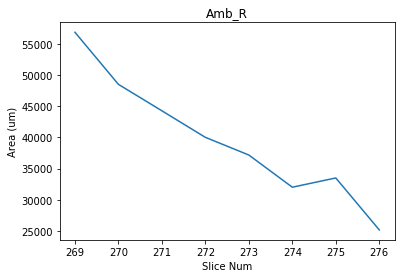

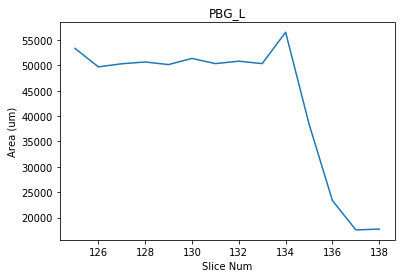

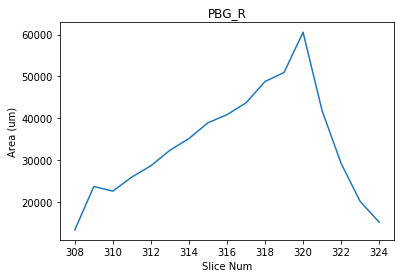

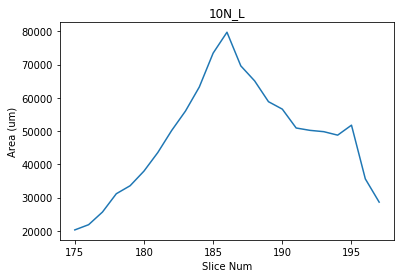

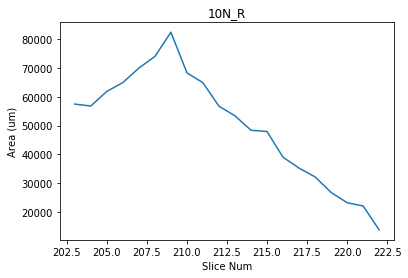

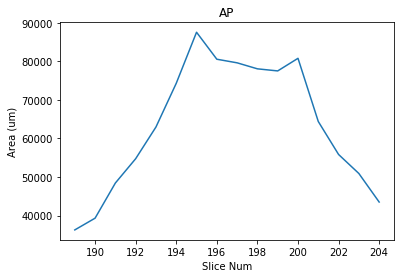

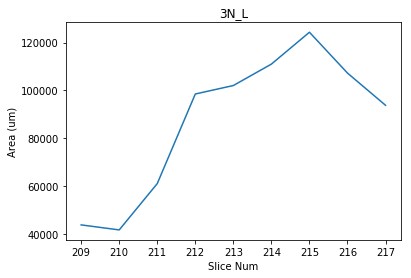

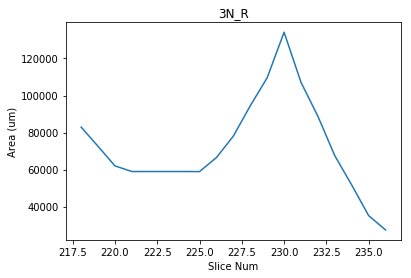

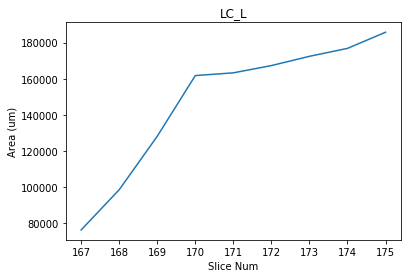

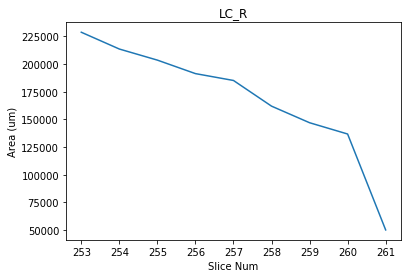

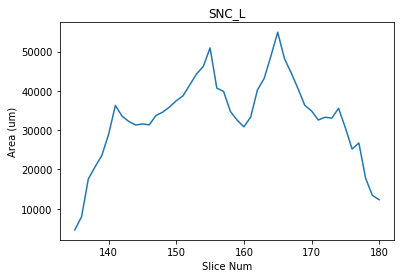

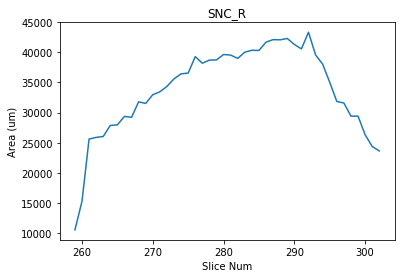

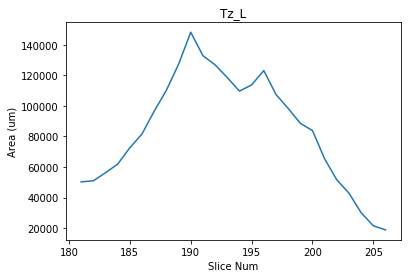

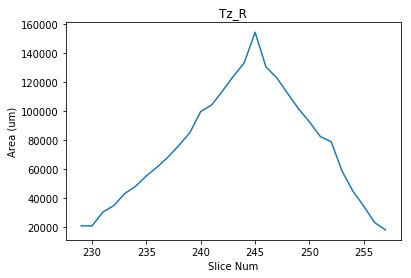

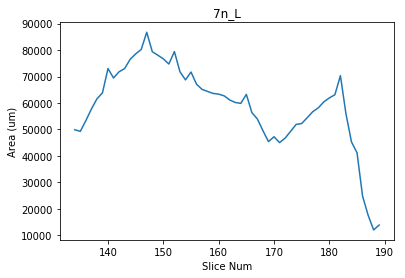

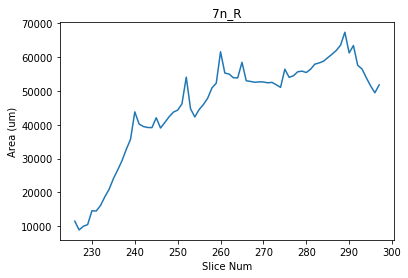

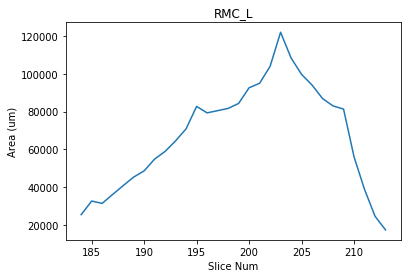

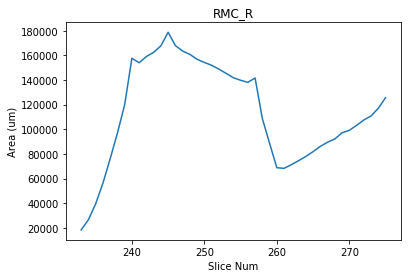

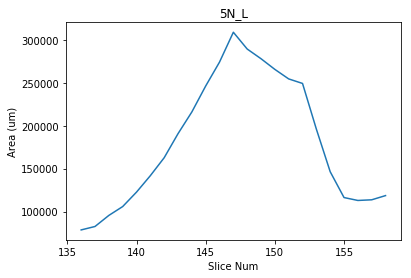

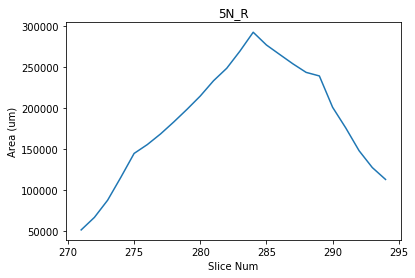

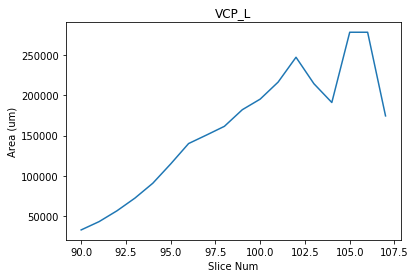

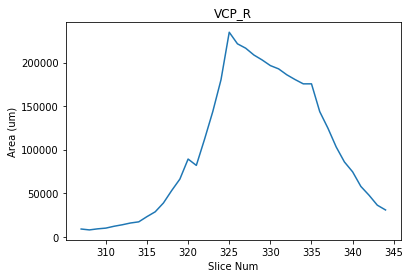

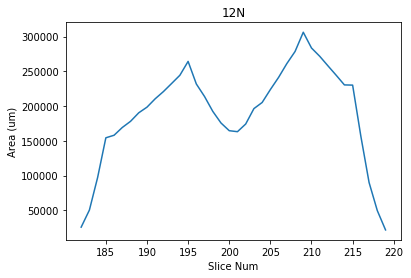

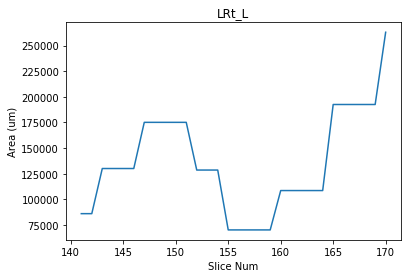

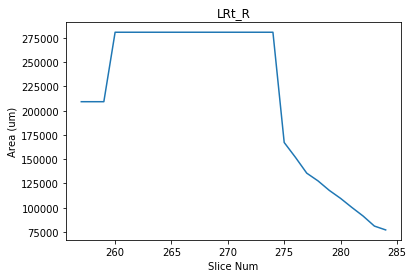

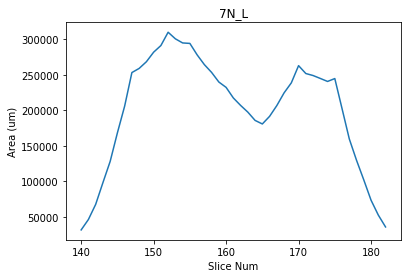

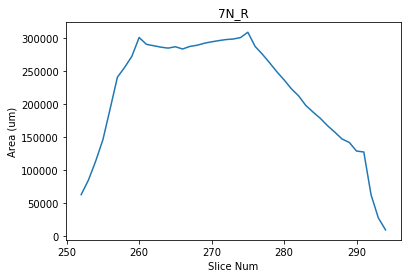

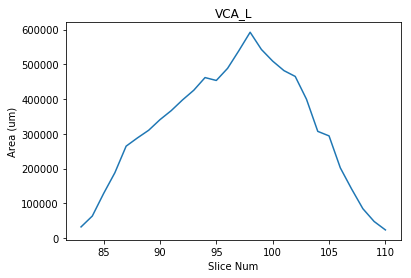

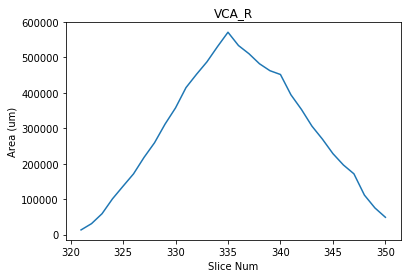

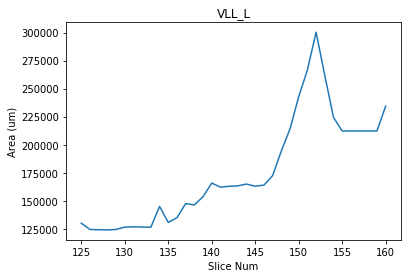

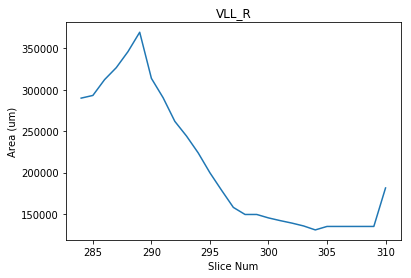

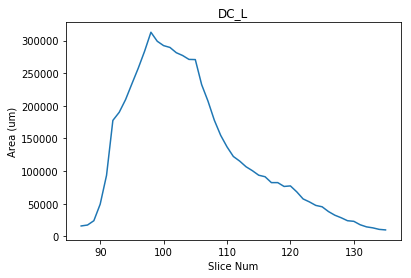

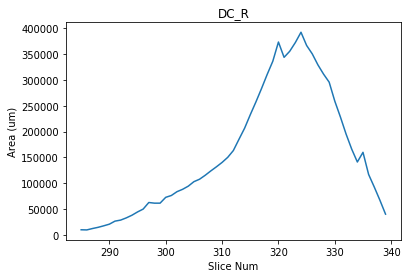

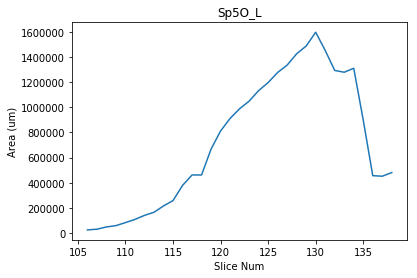

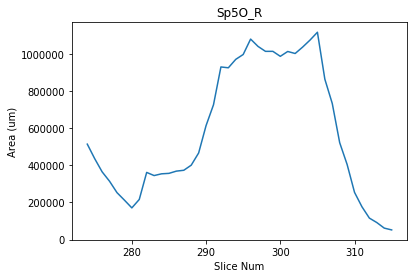

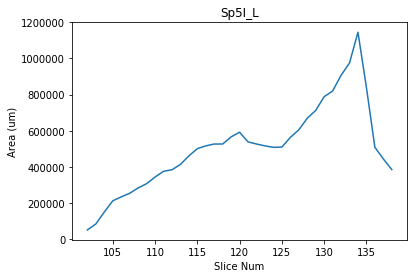

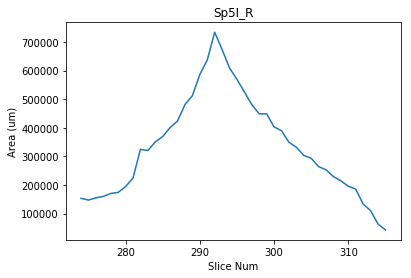

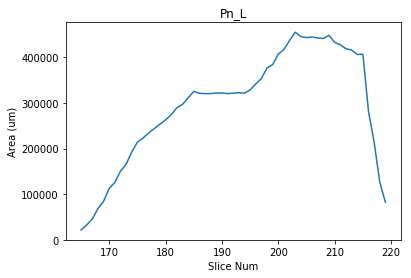

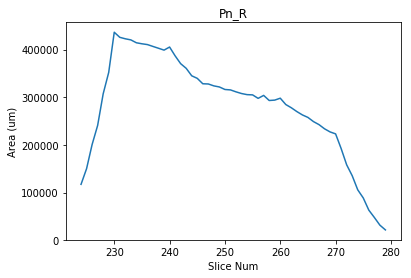

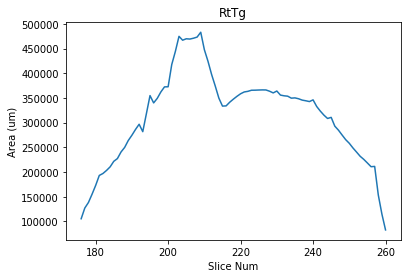

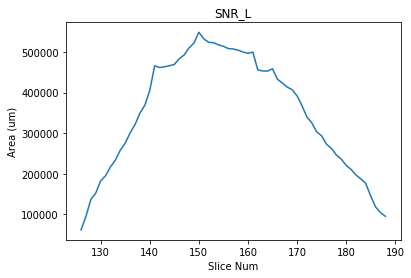

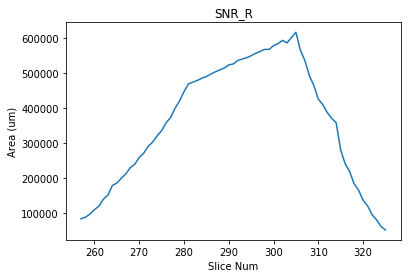

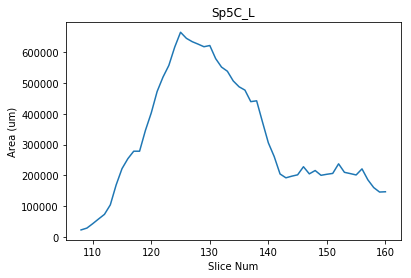

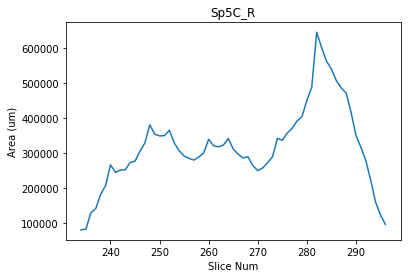

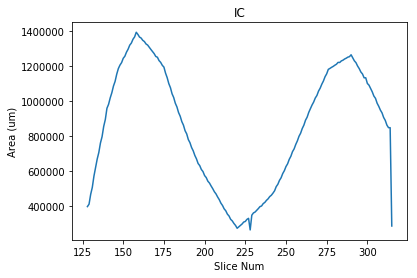

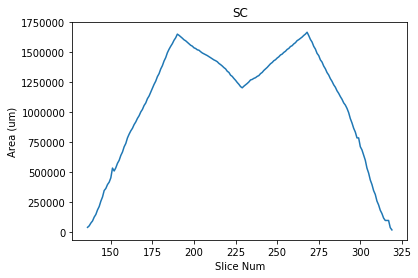

In [231]:
stack = "MD585"
stack_resolution = 0.46

structure_to_volume = {}

for target_str in structures_sided_sorted_by_size:
    total_volume, structure_area_by_slice = \
        get_structure_volume( stack=stack, target_str=target_str, stack_resolution=stack_resolution, plot=True)
    structure_to_volume[target_str] = total_volume #* 0.001**3

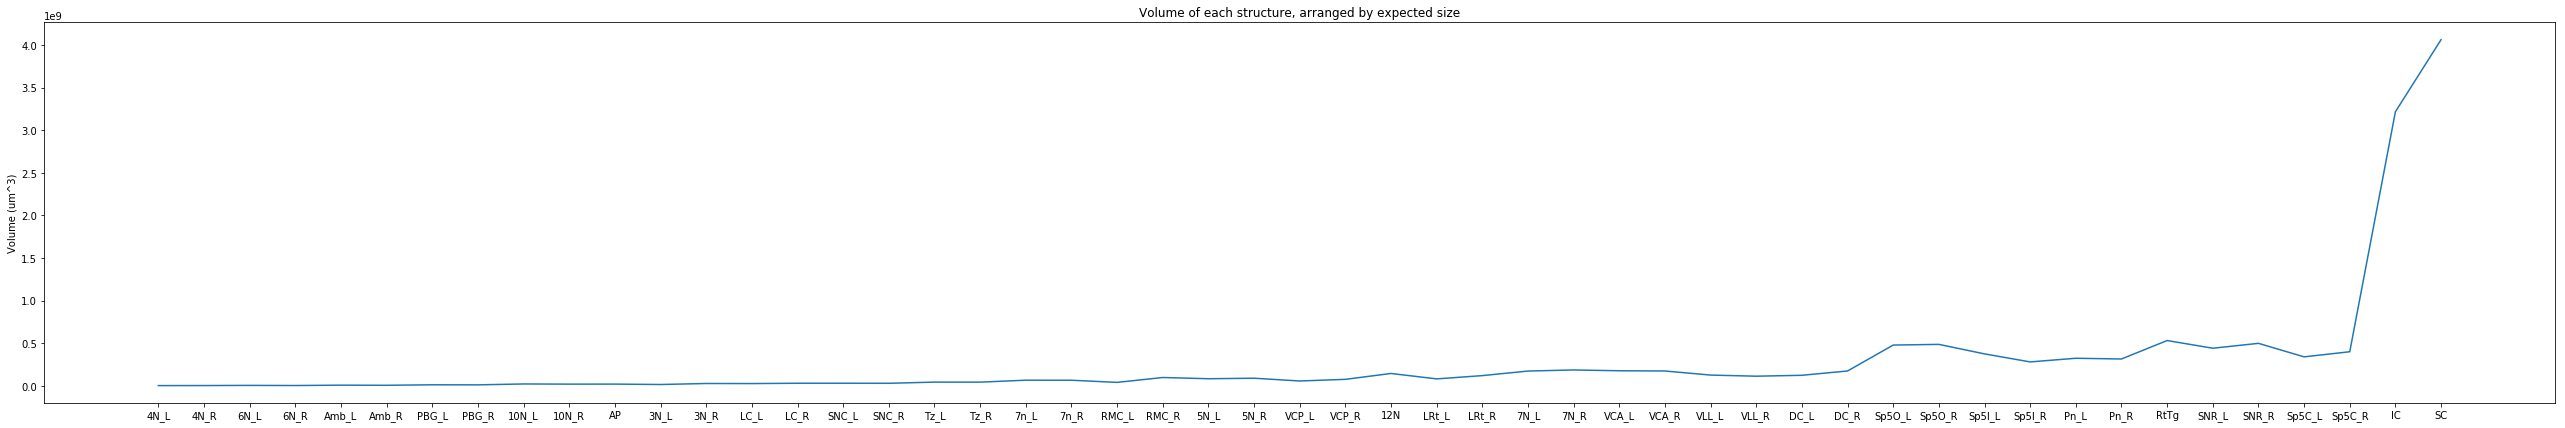

In [232]:
# Print Size of structures over time

vols = []
vols_indices = []
i = 0
for target_str in structures_sided_sorted_by_size:
#     print target_str
#     print structure_to_volume[target_str]
    vols.append( structure_to_volume[target_str] )
    vols_indices.append(i)
    i += 1
    
plt.figure( figsize=(45, 7) )

plt.plot( vols_indices, vols )
# plt.xlabel( structures_sided_sorted_by_size )
plt.ylabel('Volume (um^3)')
plt.xticks( np.arange(len(structures_sided_sorted_by_size)), structures_sided_sorted_by_size )
plt.title('Volume of each structure, arranged by expected size')
plt.show()

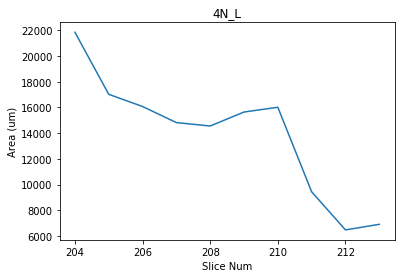

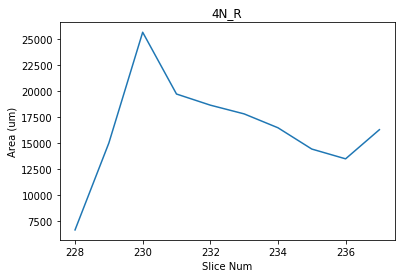

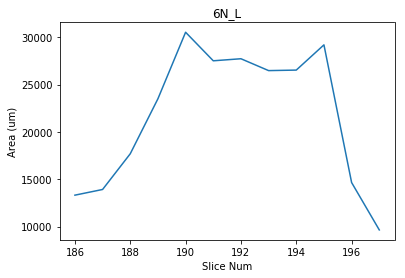

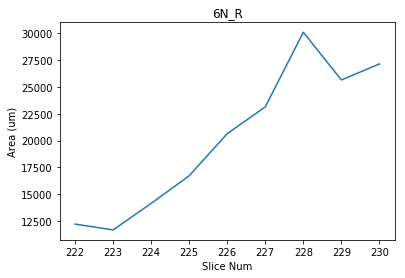

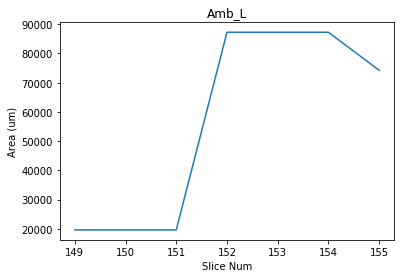

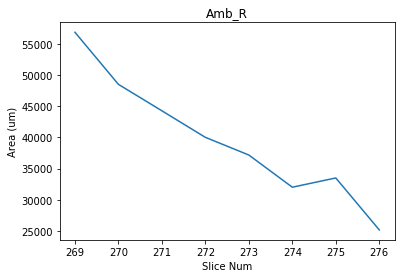

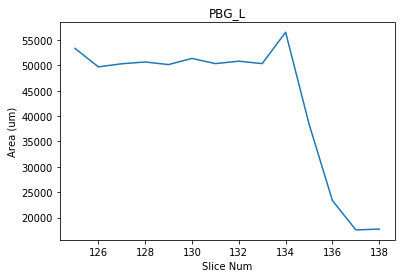

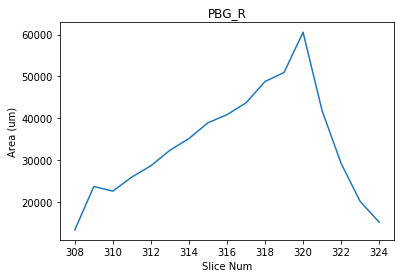

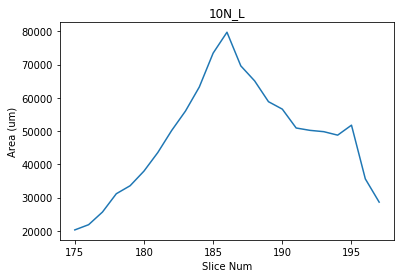

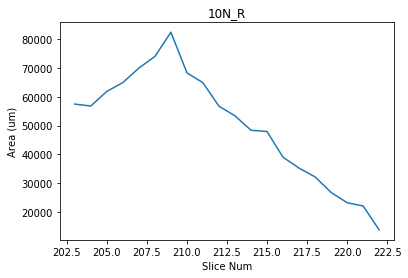

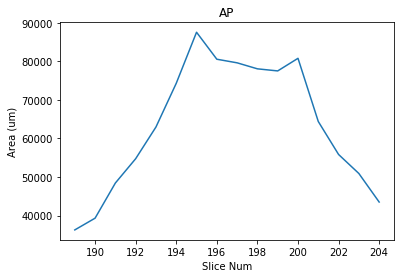

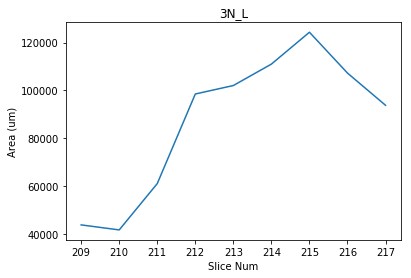

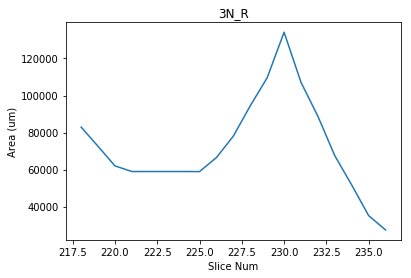

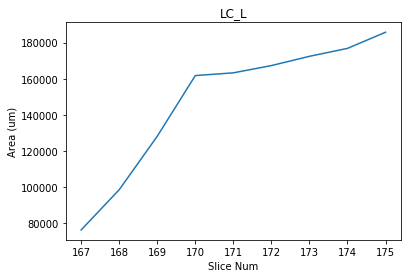

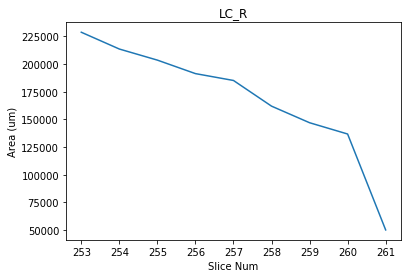

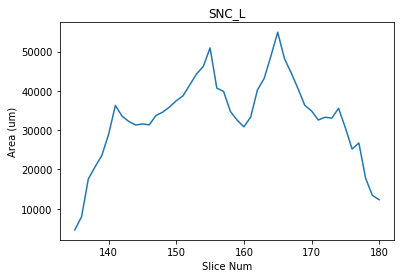

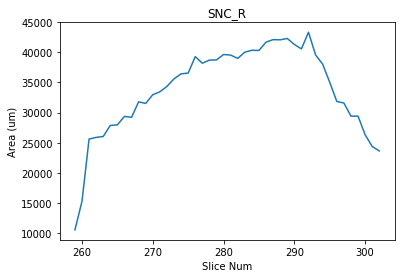

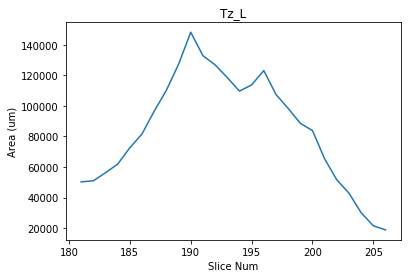

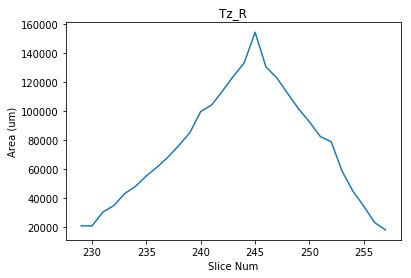

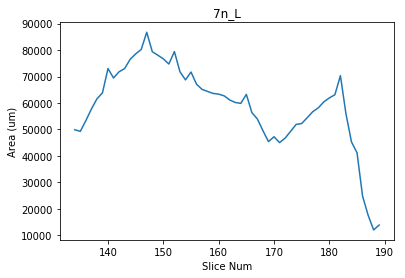

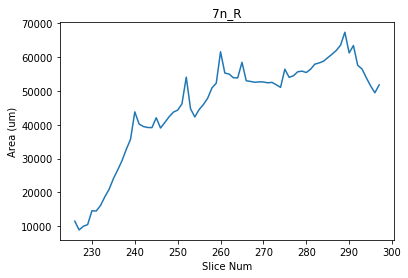

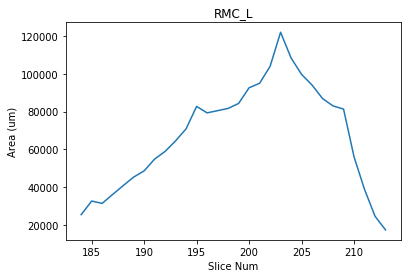

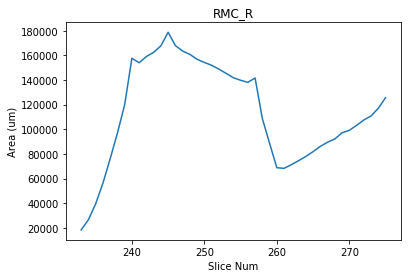

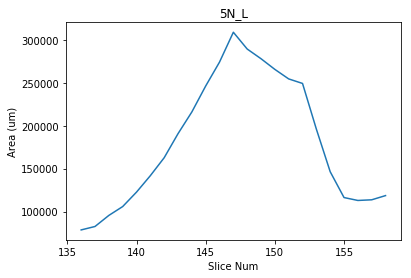

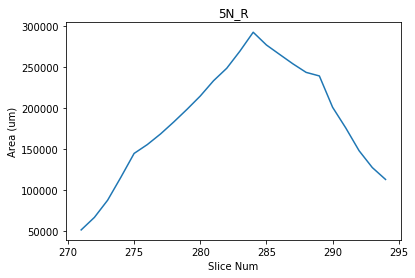

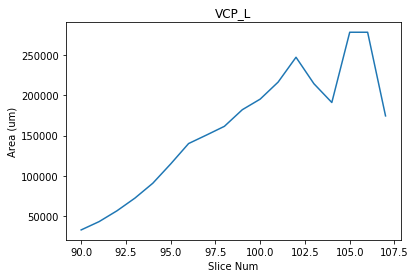

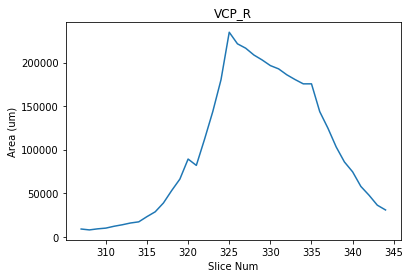

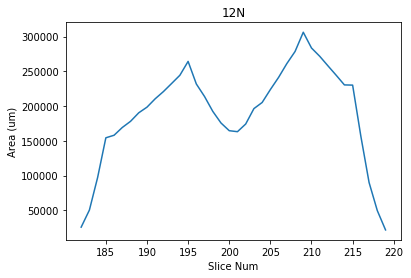

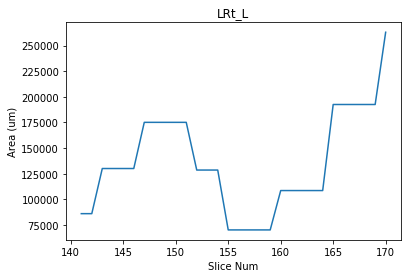

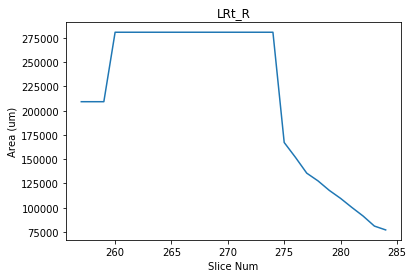

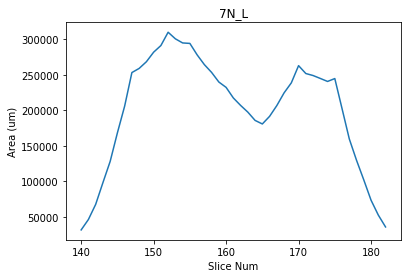

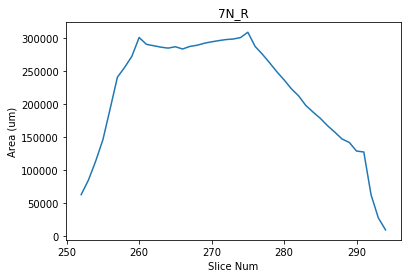

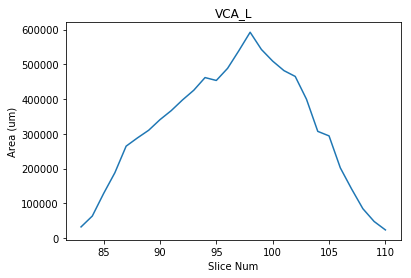

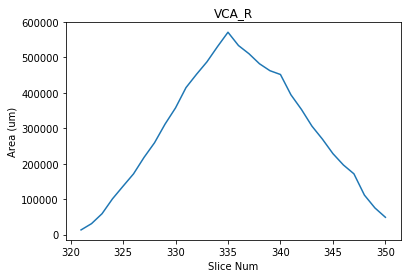

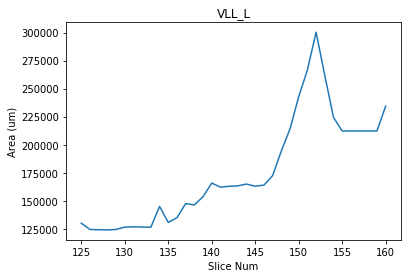

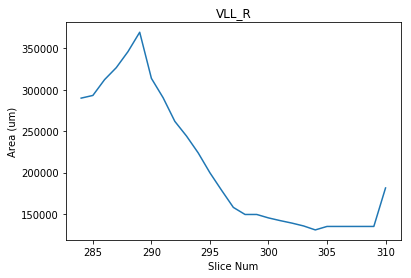

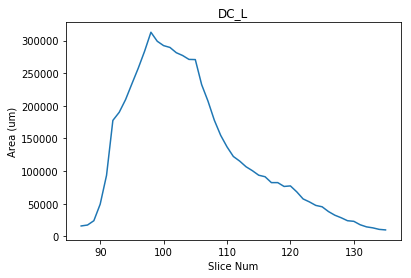

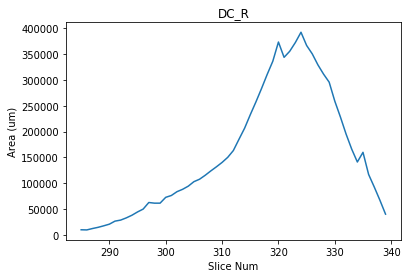

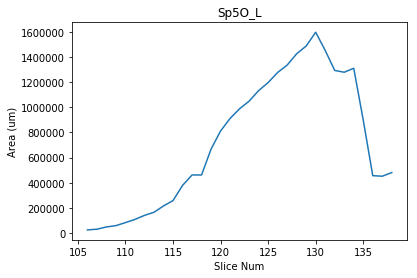

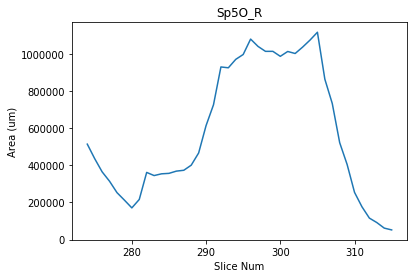

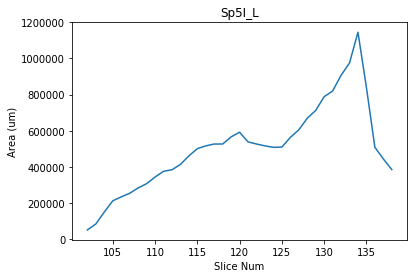

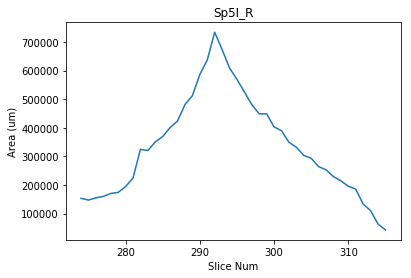

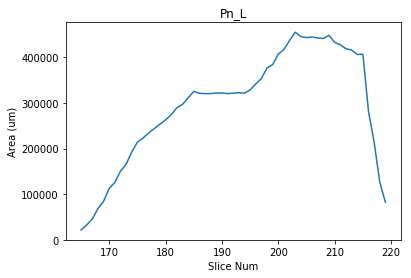

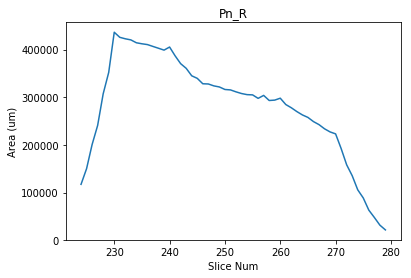

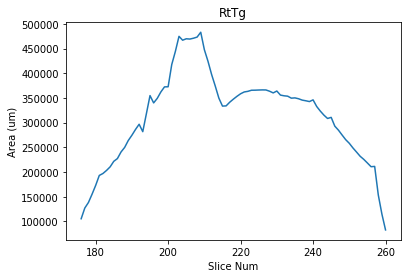

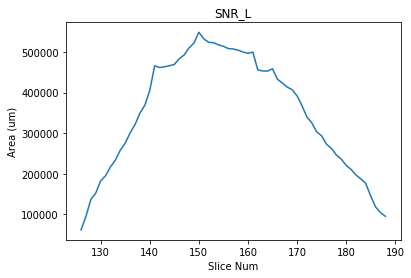

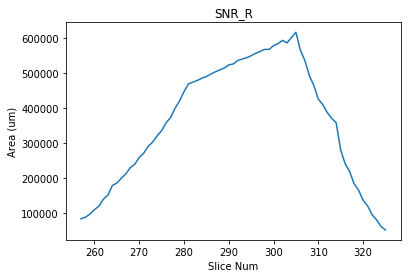

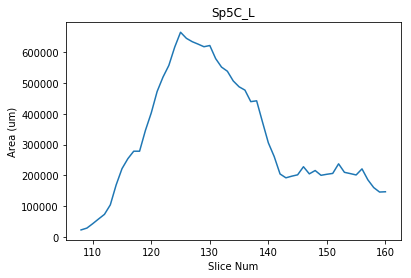

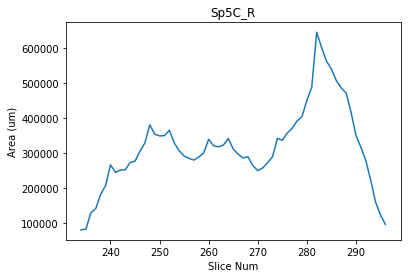

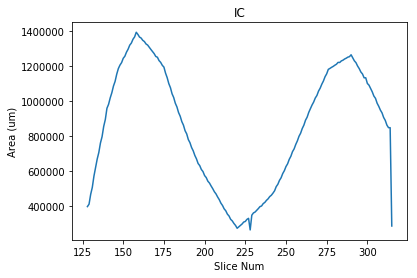

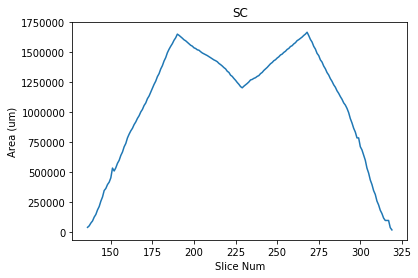

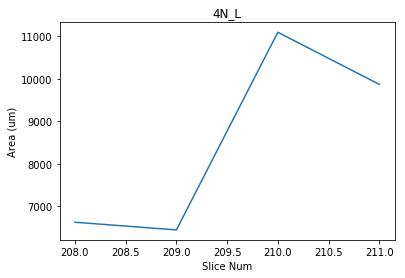

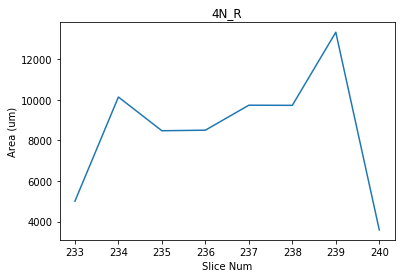

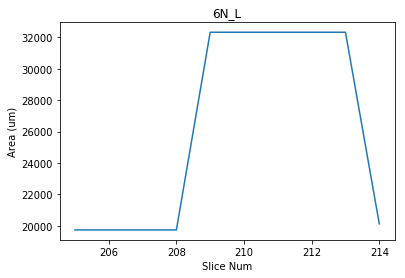

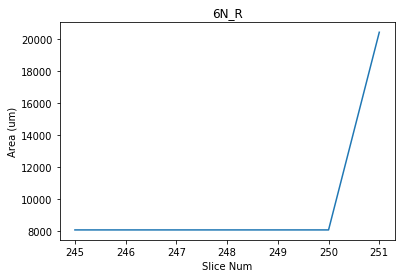

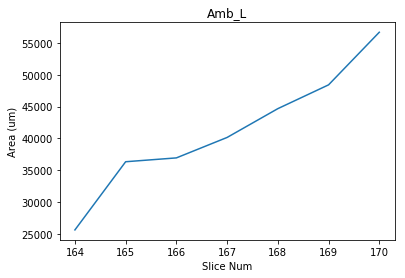

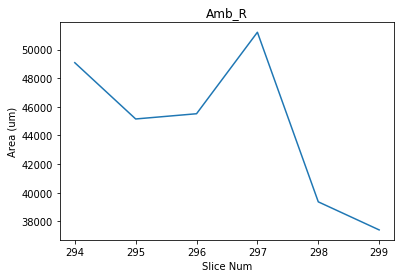

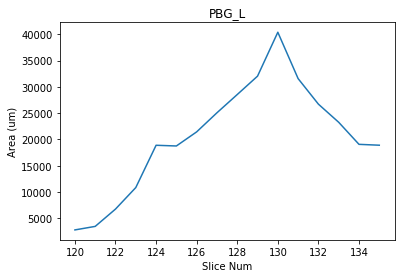

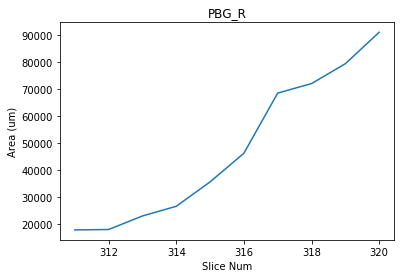

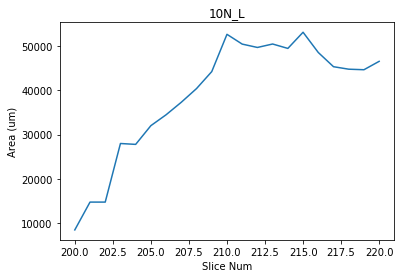

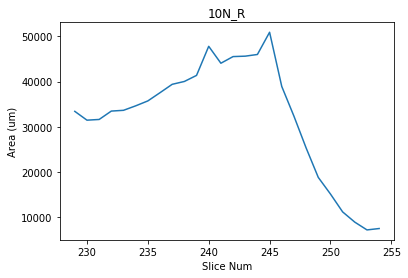

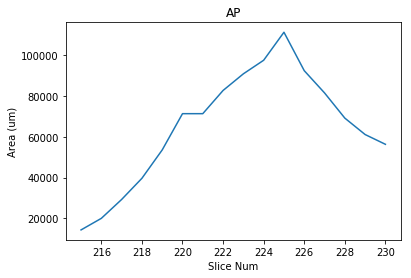

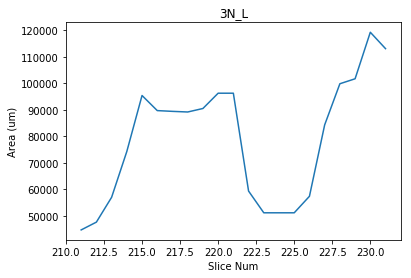

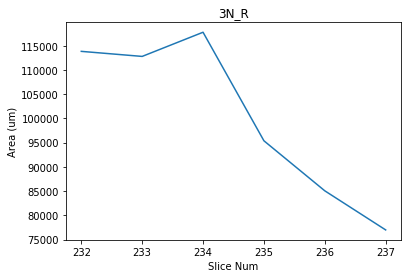

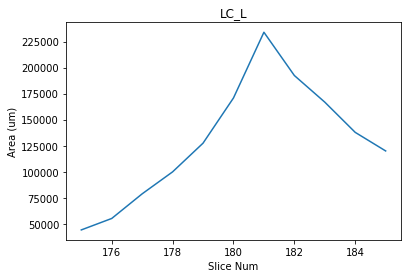

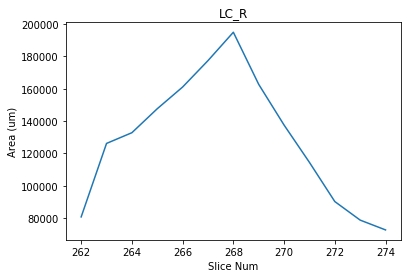

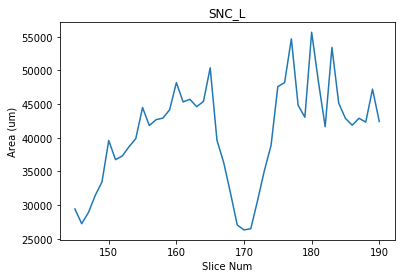

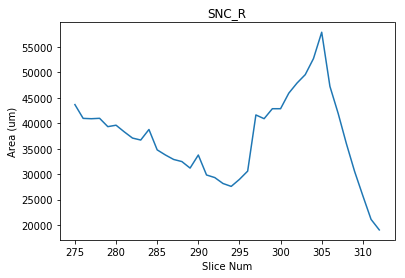

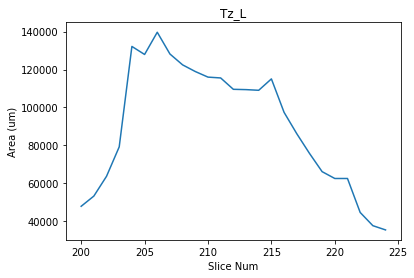

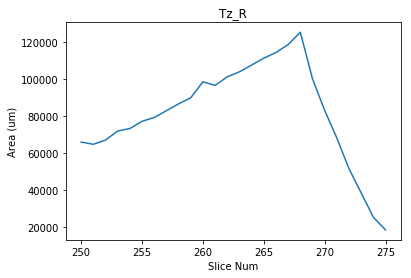

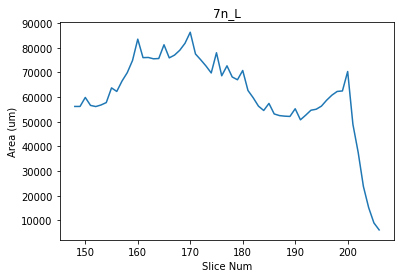

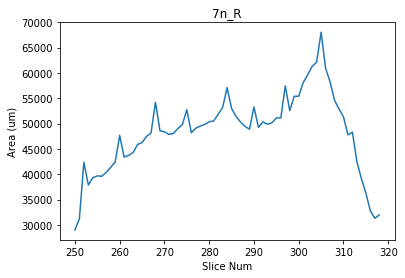

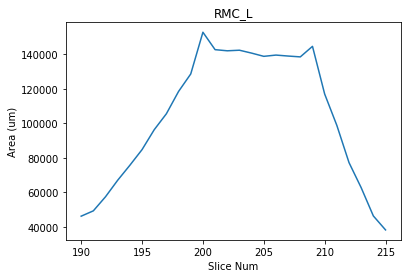

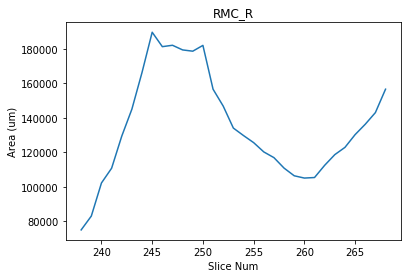

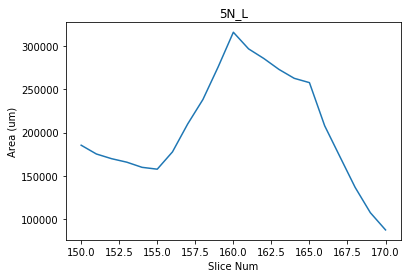

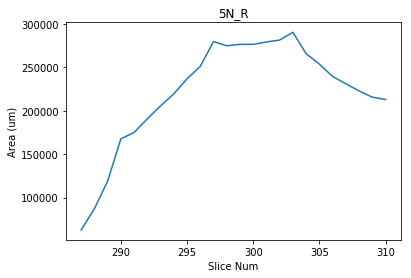

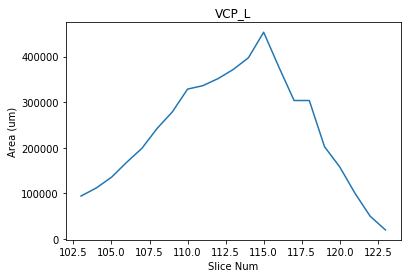

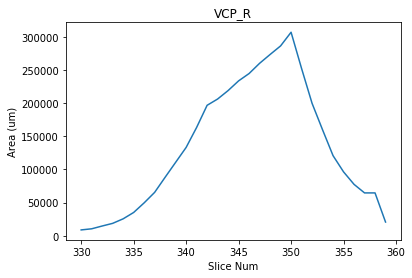

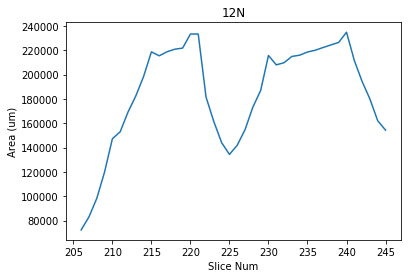

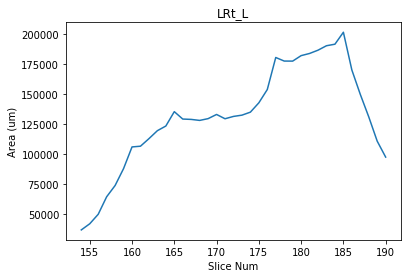

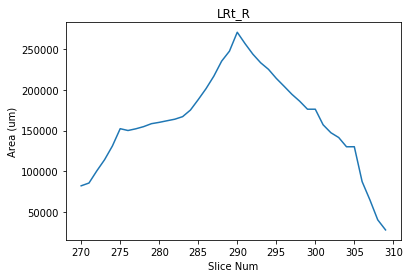

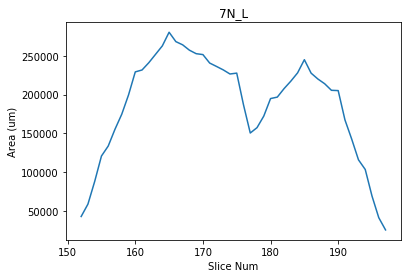

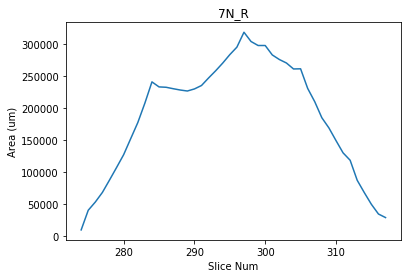

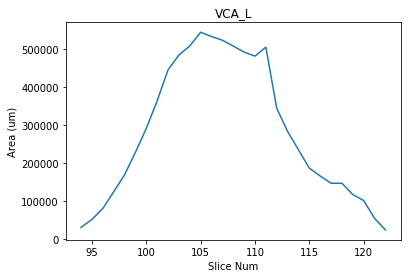

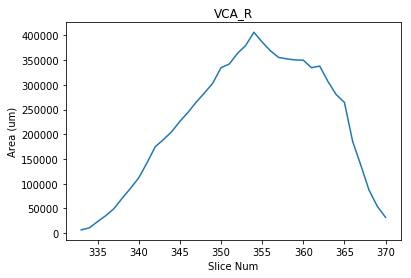

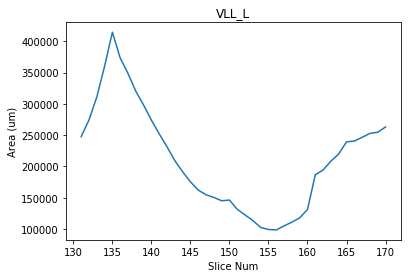

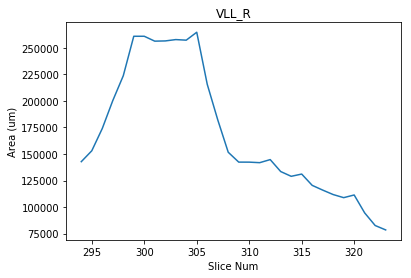

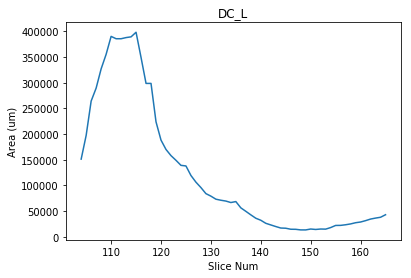

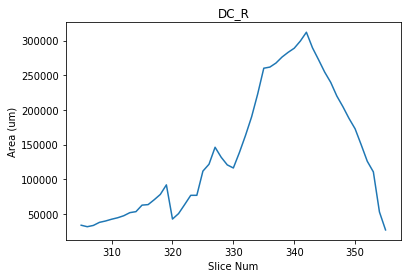

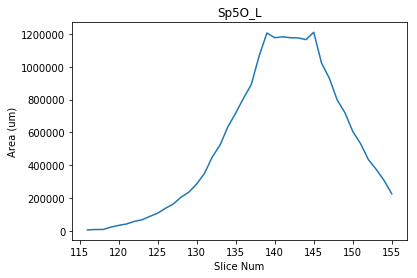

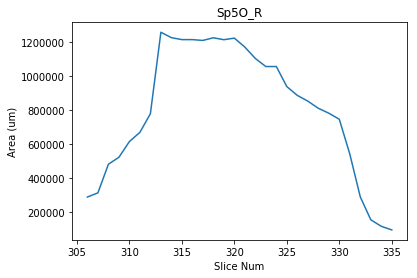

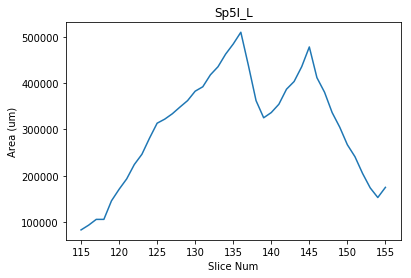

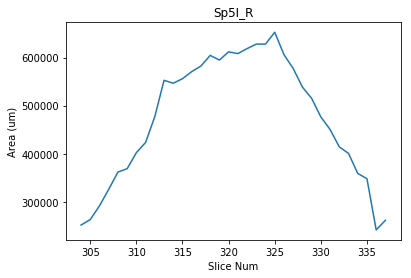

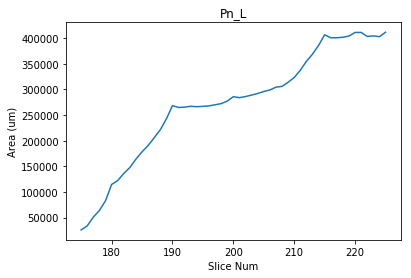

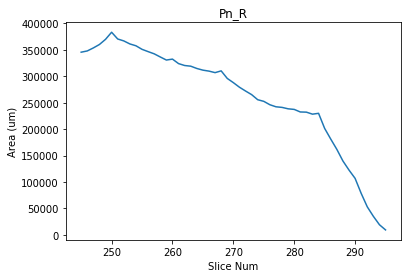

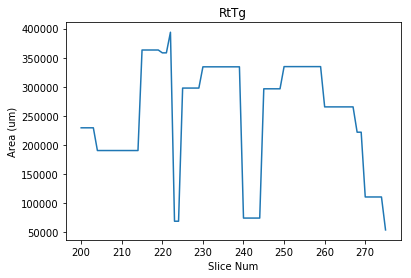

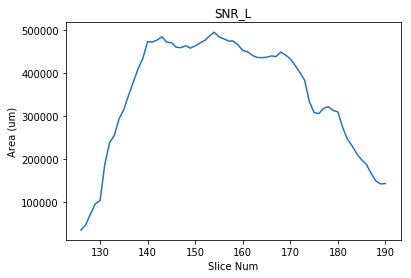

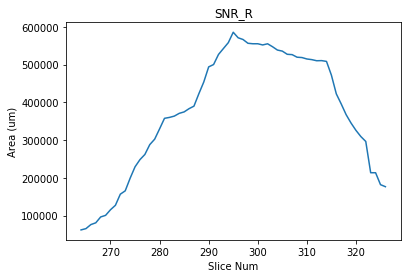

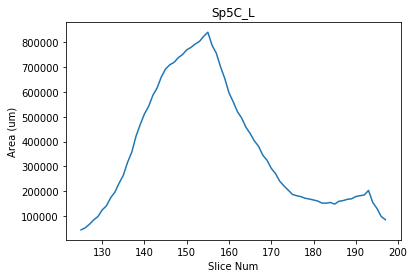

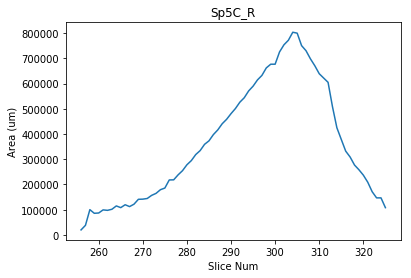

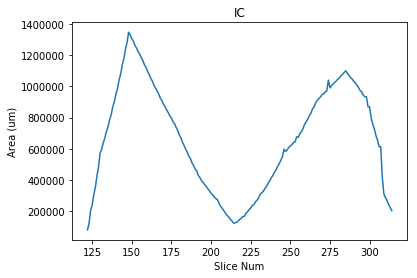

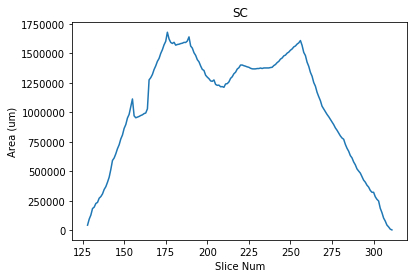

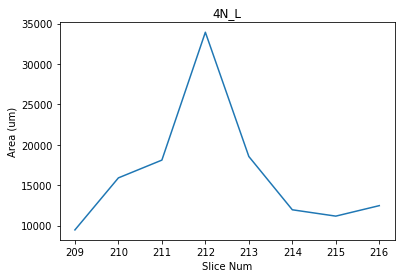

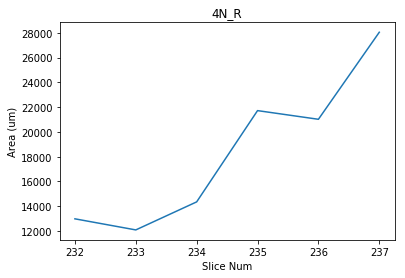

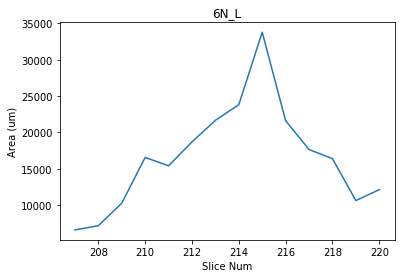

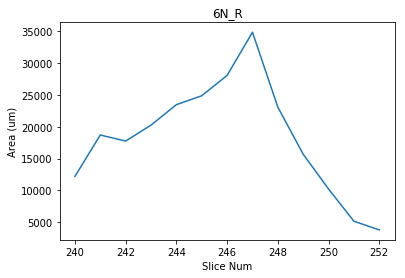

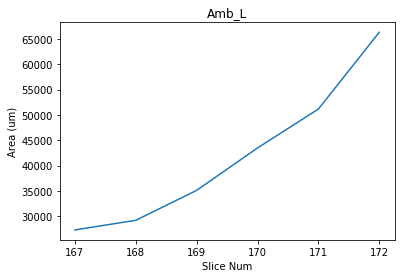

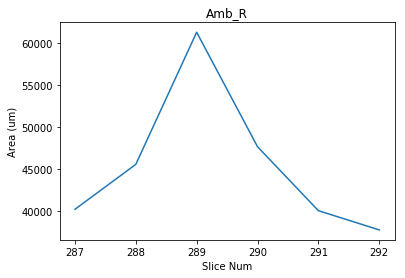

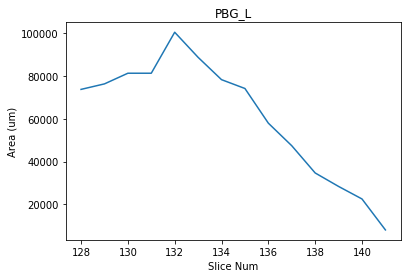

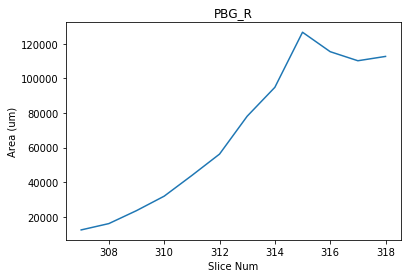

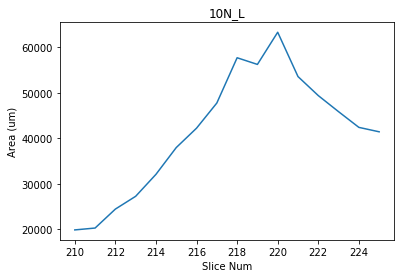

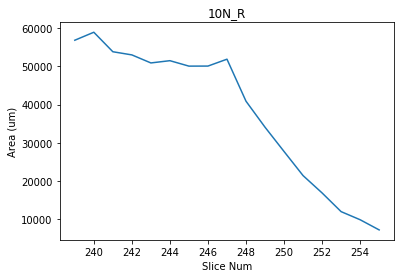

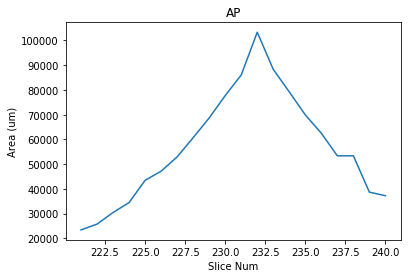

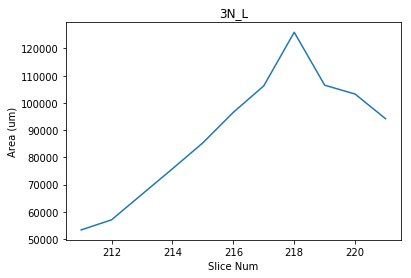

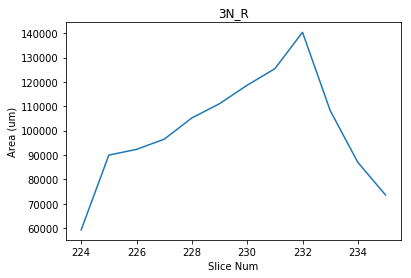

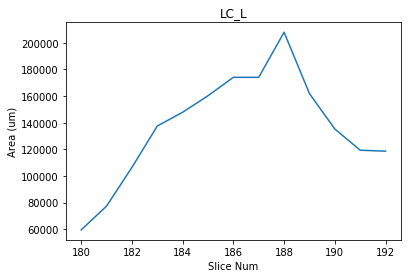

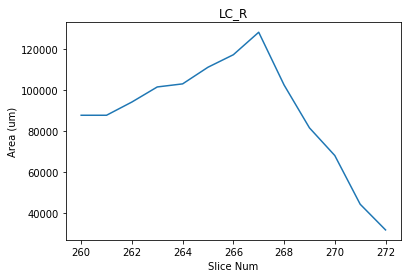

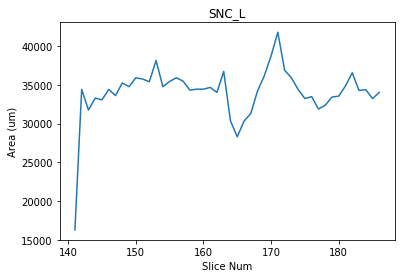

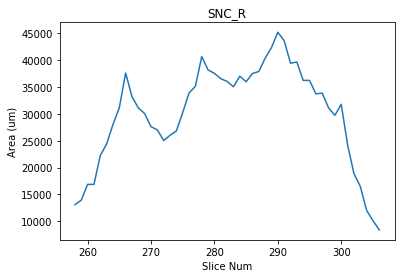

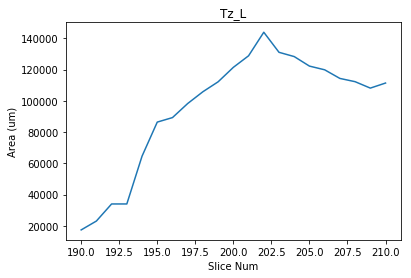

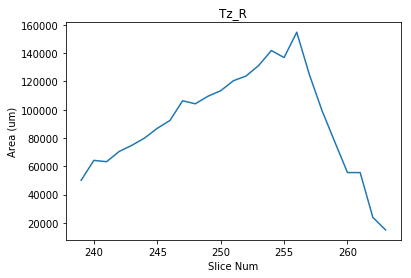

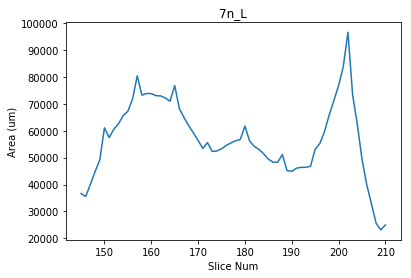

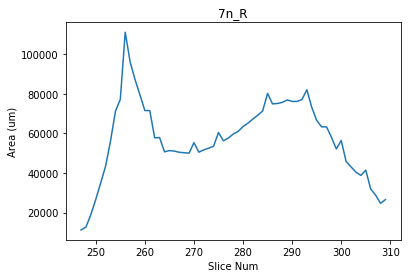

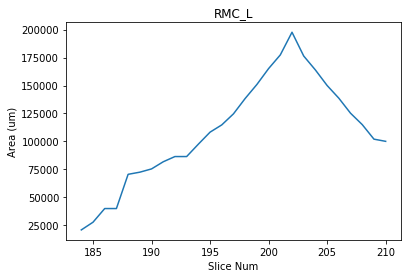

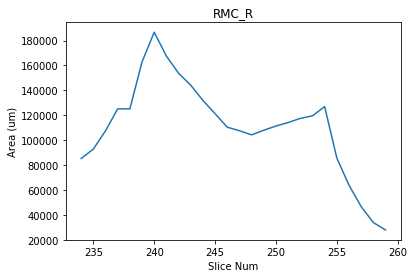

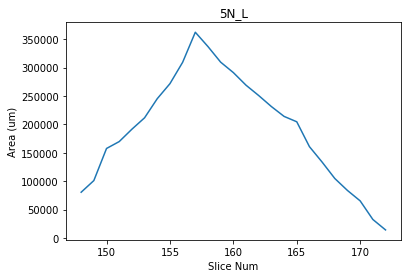

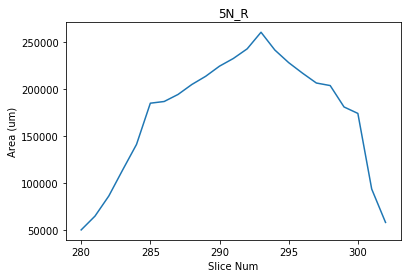

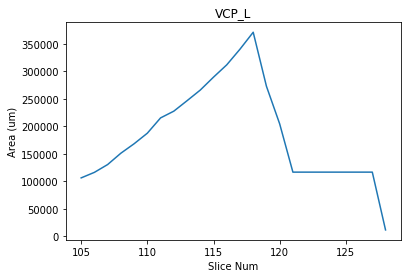

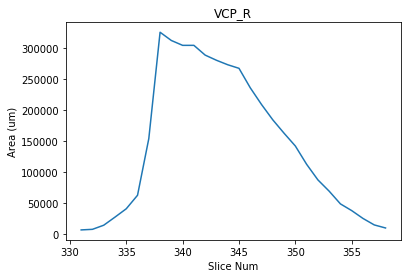

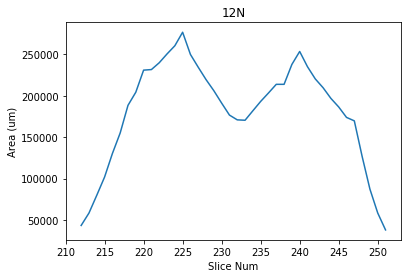

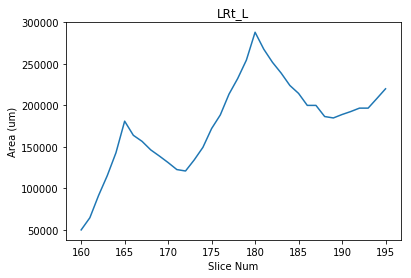

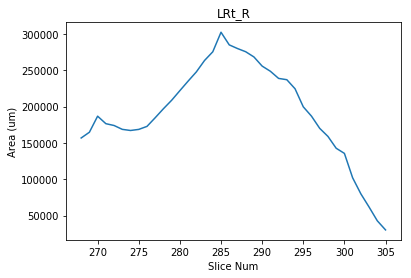

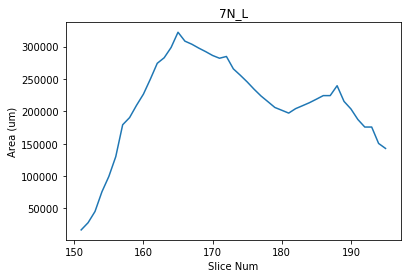

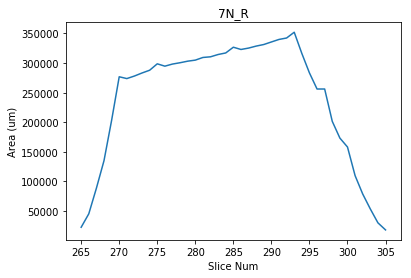

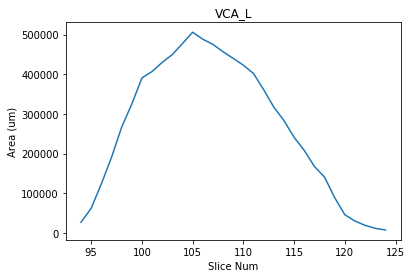

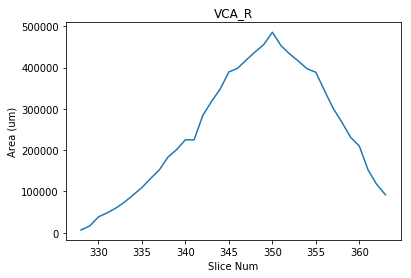

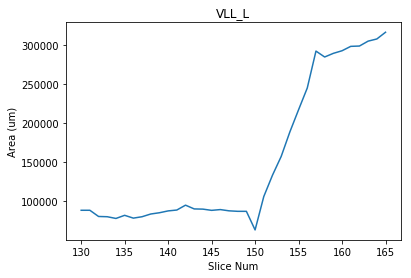

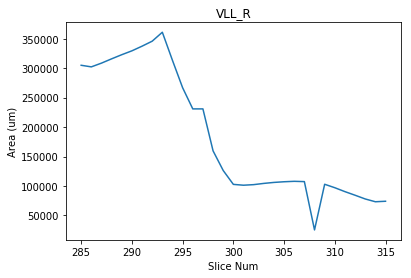

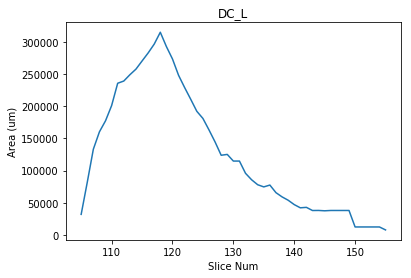

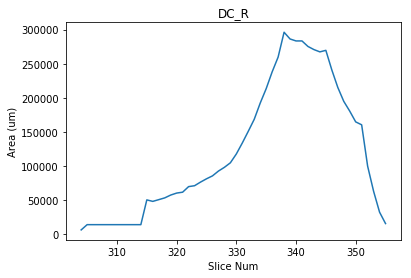

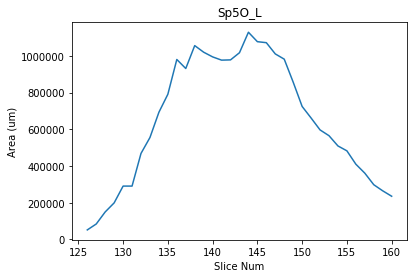

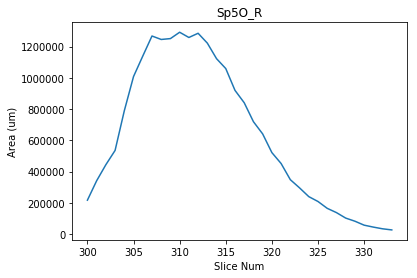

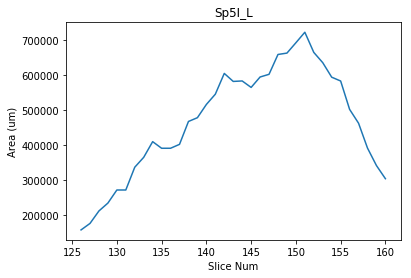

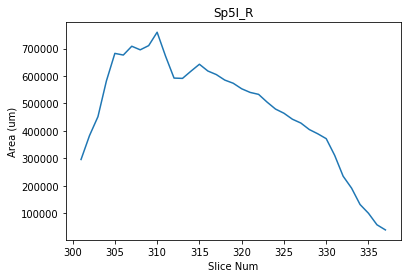

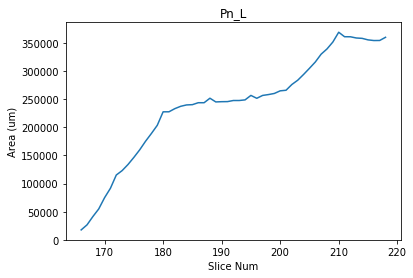

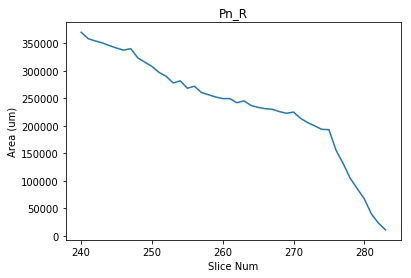

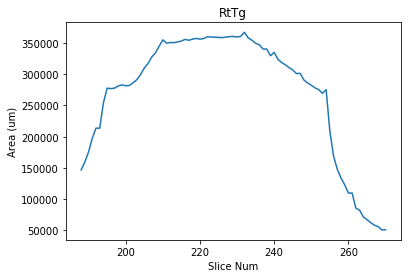

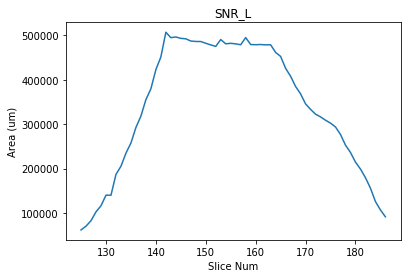

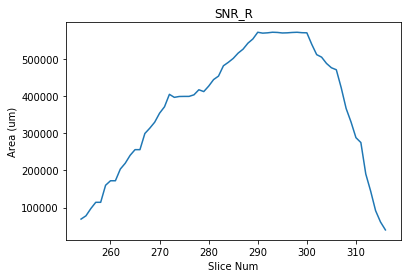

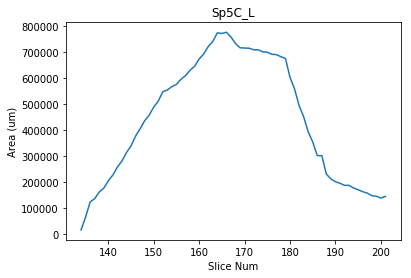

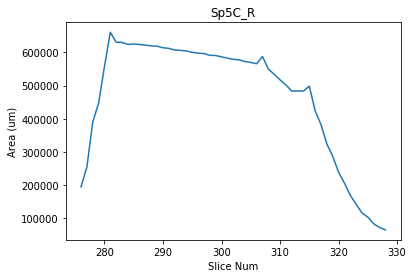

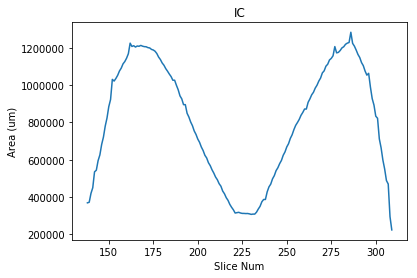

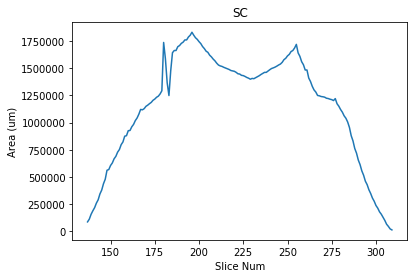

In [248]:
# Compute volume of every structure for each stack
stack_resolution = 0.46
structure_to_volume = {}
for stack in ["MD585","MD589","MD594"]:
    structure_to_volume[stack] = {}

    for target_str in structures_sided_sorted_by_size:
        total_volume, structure_area_by_slice = \
            get_structure_volume( stack=stack, target_str=target_str, stack_resolution=stack_resolution, plot=True)
        structure_to_volume[stack][target_str] = total_volume #* 0.001**3

In [317]:
def get_str_without_side(target_str):
    if '_' in target_str:
        sideless_target_str = target_str[0:target_str.index('_')]
    else:
        sideless_target_str = target_str
    return sideless_target_str

# Group volumes by structure exclusively
annotation_volume_by_str = {}

for target_str in structures_sided_sorted_by_size:
    annotation_volume_by_str[ get_str_without_side(target_str) ] = []

for stack in ["MD585","MD589","MD594"]:
    
    for target_str in structures_sided_sorted_by_size:
        volume_um_cubed = structure_to_volume[stack][target_str]
        sideless_target_str = get_str_without_side(target_str)
        
        annotation_volume_by_str[sideless_target_str].append( volume_um_cubed )

# annotation_volume_by_str[sideless_target_str]

mesh_to_polydata: No faces are provided, so skip simplification.
simplify 0 @ 430: 0.02 seconds


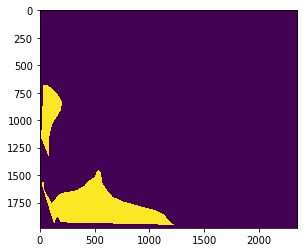

In [447]:
structure_vertices, first_section, last_section = get_structure_vertices( stack="MD585", target_str="12N" )
vertices_3D = []
for z_plane in structure_vertices.keys():
    for x, y in structure_vertices[z_plane]:
        vertices_3D.append( [x,y,z_plane] )

polydata = vertices_to_surface( vertices_3D, num_simplify_iter=1, smooth=True, neighborhood_size=None, sample_spacing=None)
volume = polydata_to_volume(polydata)
plt.imshow( volume[0][:,:,70] )

mesh_to_polydata: No faces are provided, so skip simplification.
simplify 0 @ 889: 0.02 seconds


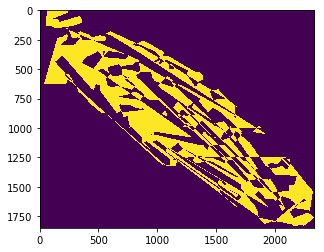

In [451]:
structure_vertices, first_section, last_section = get_structure_vertices( stack="MD585", target_str="12N" )
vertices_3D = []
for z_plane in structure_vertices.keys():
    for x, y in structure_vertices[z_plane]:
        vertices_3D.append( [x,y,z_plane] )

polydata = vertices_to_surface( vertices_3D, num_simplify_iter=1, smooth=False, neighborhood_size=1, sample_spacing=0)
volume = polydata_to_volume(polydata)
plt.imshow( volume[0][:,:,70] )

mesh_to_polydata: No faces are provided, so skip simplification.
simplify 0 @ 1142: 0.03 seconds


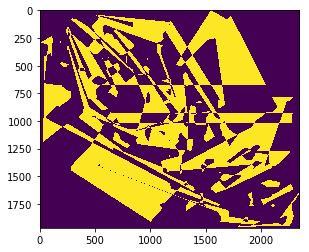

In [452]:
structure_vertices, first_section, last_section = get_structure_vertices( stack="MD585", target_str="12N" )
vertices_3D = []
for z_plane in structure_vertices.keys():
    for x, y in structure_vertices[z_plane]:
        vertices_3D.append( [x,y,z_plane] )

polydata = vertices_to_surface( vertices_3D, num_simplify_iter=1, smooth=False, neighborhood_size=2, sample_spacing=0)
volume = polydata_to_volume(polydata)
plt.imshow( volume[0][:,:,70] )

# Volume from Atlas_V7 Structure Volumes

In [207]:
def get_npz_data(filename):
    filename = filename+'.npz'
    filecontents = np.load(filename)
    data = filecontents['data']
    del filecontents
    return data


def blosc_to_npz(filename):
    file = filename+".bp";

    a = bp.unpack_ndarray_file(file)
    b = np.asarray(a)

    np.savez(filename+'.npz', data=b) # Save matrix as .npz file

    print('Size of bloscpack data:')
    print(np.shape(b))
    print('')
    
def load_atlasV7_structure_volume( structure ):
    fn = os.path.join( os.environ['ROOT_DIR'], 'CSHL_volumes', 'atlasV7', 'atlasV7_10.0um_scoreVolume', \
                      'score_volumes', 'atlasV7_10.0um_scoreVolume_'+structure )
#     blosc_to_npz(fn)
    return get_npz_data(fn)

In [472]:
# voxel_to_um_cubed = 0.1*0.1*0.05
voxel_to_um_cubed = 2000 # 10um x 10um x 20um
threshold_list = [0.5]
atlas_v7_volumes = {}

for threshold in threshold_list:
    atlas_v7_volumes[threshold] = {}

for threshold in threshold_list:
    atlas_v7_volumes[threshold] = {}
    
    for target_str in structures_sided_sorted_by_size:
        structure_vol = load_atlasV7_structure_volume( target_str ) > threshold
        num_positive_voxels = sum( x>0 for x in structure_vol.flatten() )
        volume = num_positive_voxels * voxel_to_um_cubed
        atlas_v7_volumes[threshold][target_str] = volume

In [474]:
import json
with open('atlasV7_vols.json') as f:
    atlas_v7_volumes = json.load(f)

In [297]:
atlas_v7_volumes.keys()

[u'0.9', u'0.8', u'0.925', u'0.75', u'0.85', u'0.95', u'0.88']

# Comparissons

In [350]:
structures_sided_sorted_by_size_no_right = []
for structure in structures_sided_sorted_by_size:
    if '_R' in structure:
        continue
    else:
        structures_sided_sorted_by_size_no_right.append(structure)

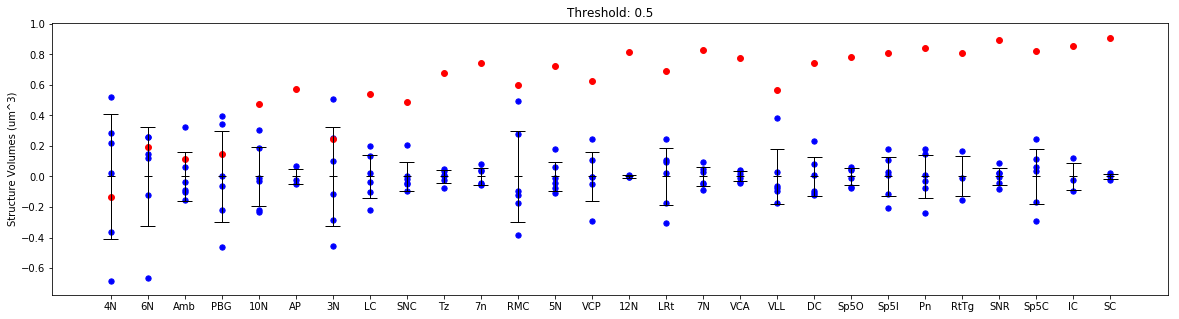

In [482]:
def scatter_plot_two_sets_with_error_bars_normalized( values_set_1, single_value_set_2, x_offset=0 ):
    mean_vals = np.mean(values_set_1)
    
    values_set_1 = np.divide( (values_set_1-mean_vals), mean_vals)
    single_value_set_2 = float(single_value_set_2-mean_vals)/mean_vals
    std_vals = np.std(values_set_1)
    mean_vals = np.mean(values_set_1)
    
    x_pos = np.zeros( (len(values_set_1)) )+x_offset
    
    plt.scatter( x_pos, values_set_1, color='b', s=28 )
    # Plot error bars
    plt.errorbar( x_pos[0]+.0, mean_vals, xerr=.11, yerr=std_vals, c='k', elinewidth=1 )
    plt.errorbar( x_pos[0]+.0, mean_vals+std_vals, xerr=.2, yerr=0, c='k', elinewidth=1 )
    plt.errorbar( x_pos[0]+.0, mean_vals-std_vals, xerr=.2, yerr=0, c='k', elinewidth=1 )
    
    plt.scatter( x_pos[0], single_value_set_2, color='r', s=35 )
    
    plt.ylabel( 'Structure Volumes (um^3)' )
    plt.xticks([])
    
def scatter_plot_two_sets_with_error_bars( values_set_1, single_value_set_2, x_offset=0 ):
    mean_vals = np.mean(values_set_1)
    std_vals = np.std(values_set_1)
    
    x_pos = np.zeros( (len(values_set_1)) )+x_offset
    
    plt.scatter( x_pos, values_set_1, color='b', s=28 )
    # Plot error bars
    plt.errorbar( x_pos[0]+.0, mean_vals, xerr=.11, yerr=std_vals, c='k', elinewidth=1 )
    plt.errorbar( x_pos[0]+.0, mean_vals+std_vals, xerr=.2, yerr=0, c='k', elinewidth=1 )
    plt.errorbar( x_pos[0]+.0, mean_vals-std_vals, xerr=.2, yerr=0, c='k', elinewidth=1 )
    
    plt.scatter( x_pos[0], single_value_set_2, color='r', s=35 )
    
    plt.ylabel( 'Structure Volumes (um^3)' )
    plt.xticks([])
    
threshold = "0.5"
# structure_chunk_limits = [[0,10],[10,20],[20,26],[26,28]]
structure_chunk_limits = [[0,28]]

for limits in structure_chunk_limits:
    structure_subset_chunk = structures_sided_sorted_by_size_no_right[limits[0]:limits[1]]
    x_offset=0
    plt.figure( figsize=(20, 5) )

    for target_str in structure_subset_chunk:
        ha_volumes = annotation_volume_by_str[ get_str_without_side(target_str) ]

        atlasV7_vol = atlas_v7_volumes[threshold][target_str]

        try:
            scatter_plot_two_sets_with_error_bars_normalized( ha_volumes, atlasV7_vol, x_offset )
#             scatter_plot_two_sets_with_error_bars( ha_volumes, atlasV7_vol, x_offset )
            x_offset+=1
        except Exception as e:
            print(e)
    
    structure_subset_chunk = [get_str_without_side(i) for i in structure_subset_chunk]
    
    plt.title( 'Threshold: '+threshold, loc='center' )
    plt.xticks( np.arange(len(structure_subset_chunk)), structure_subset_chunk )
    plt.show()

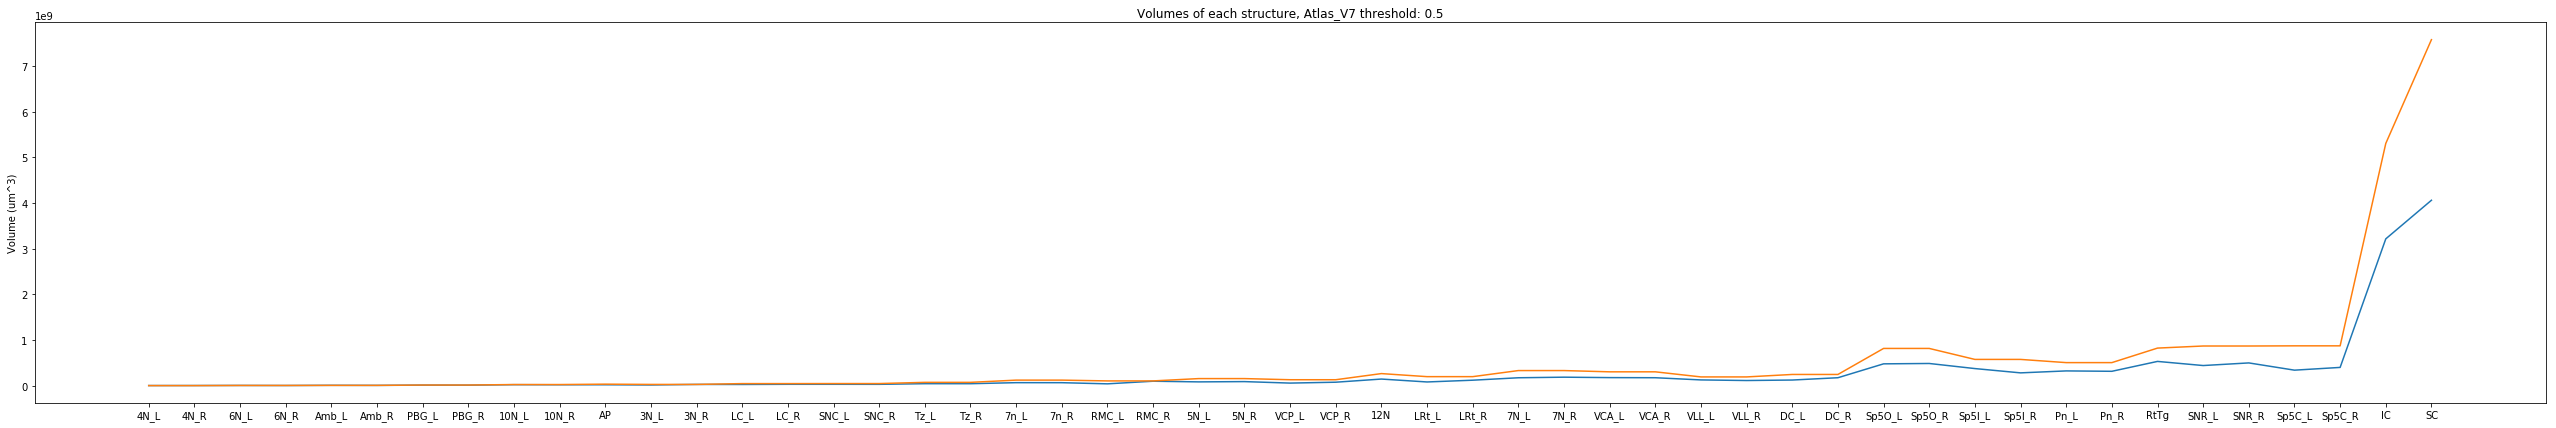

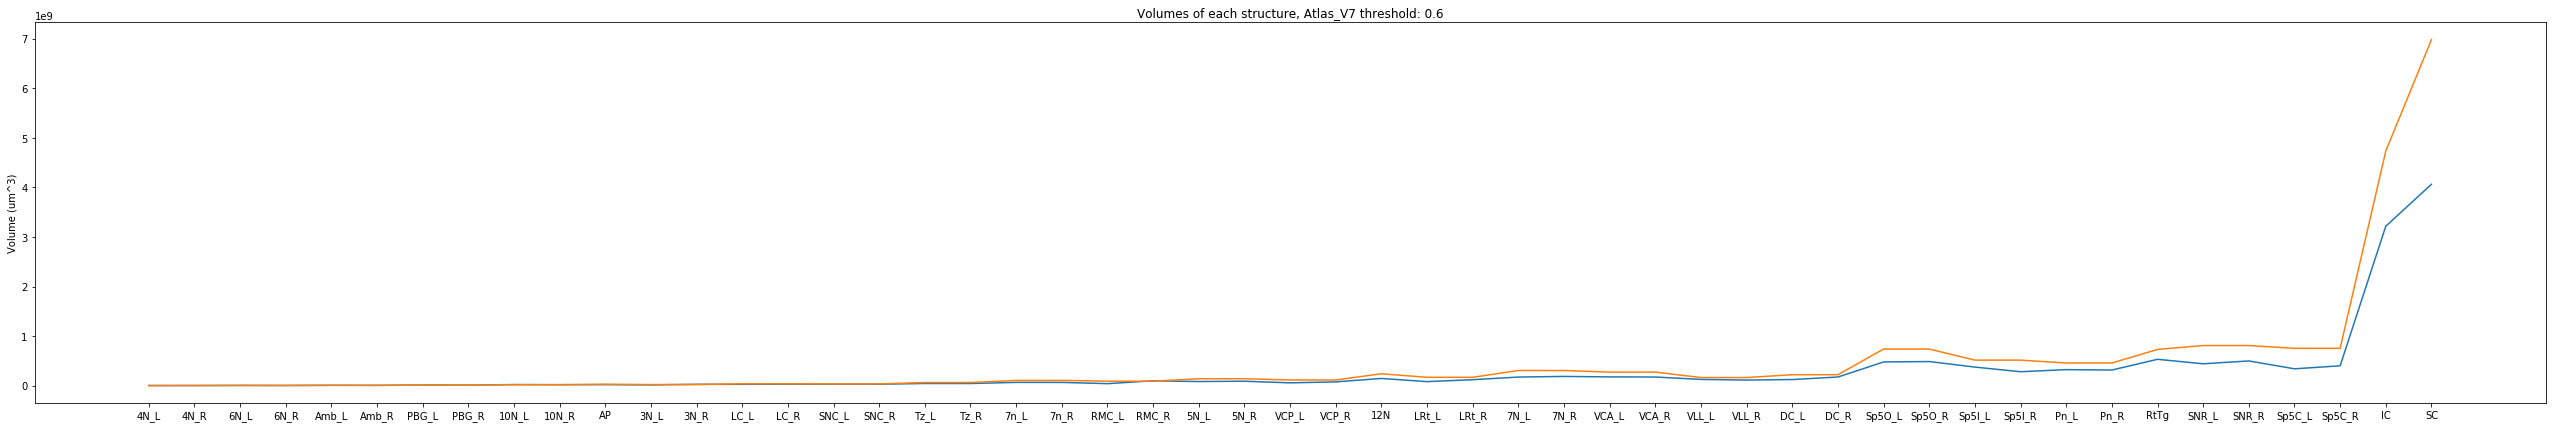

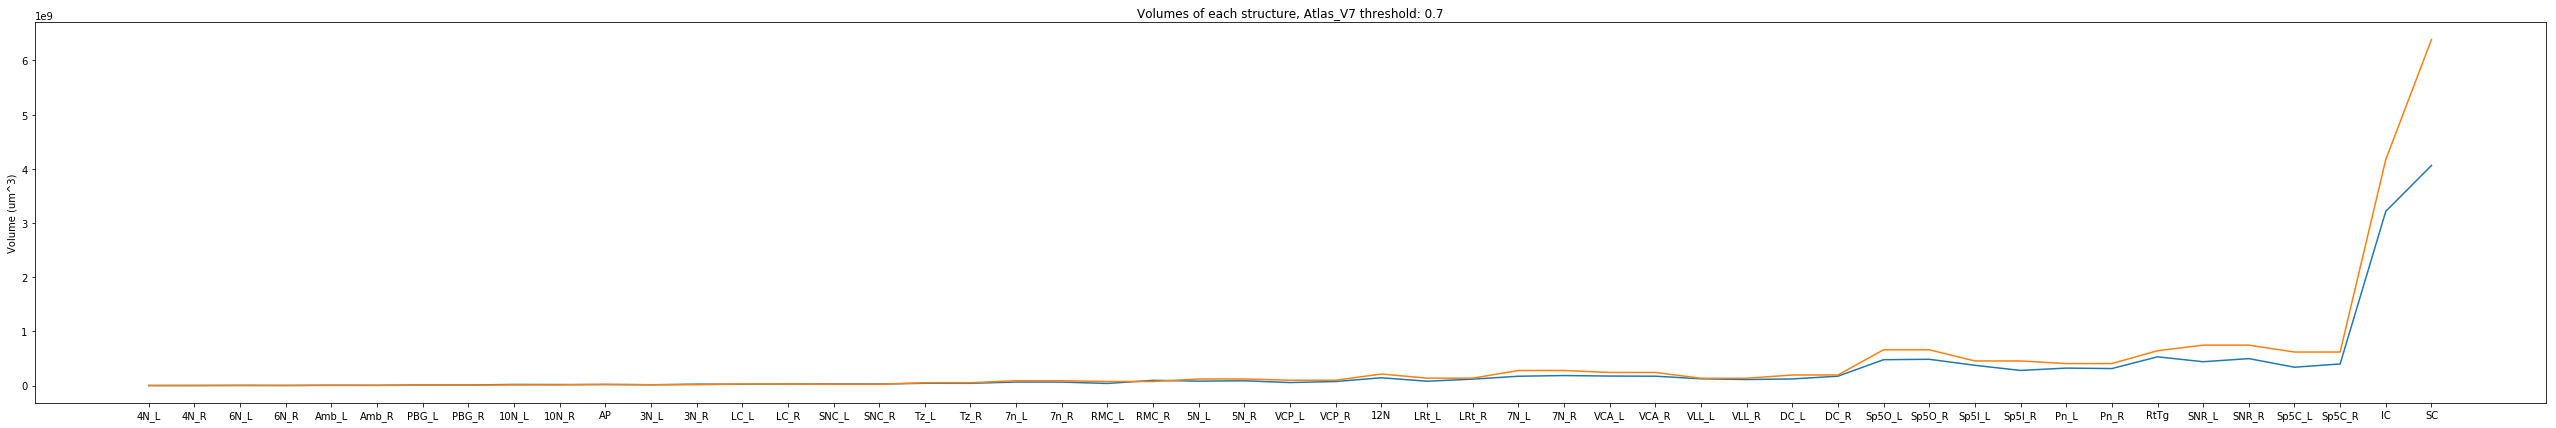

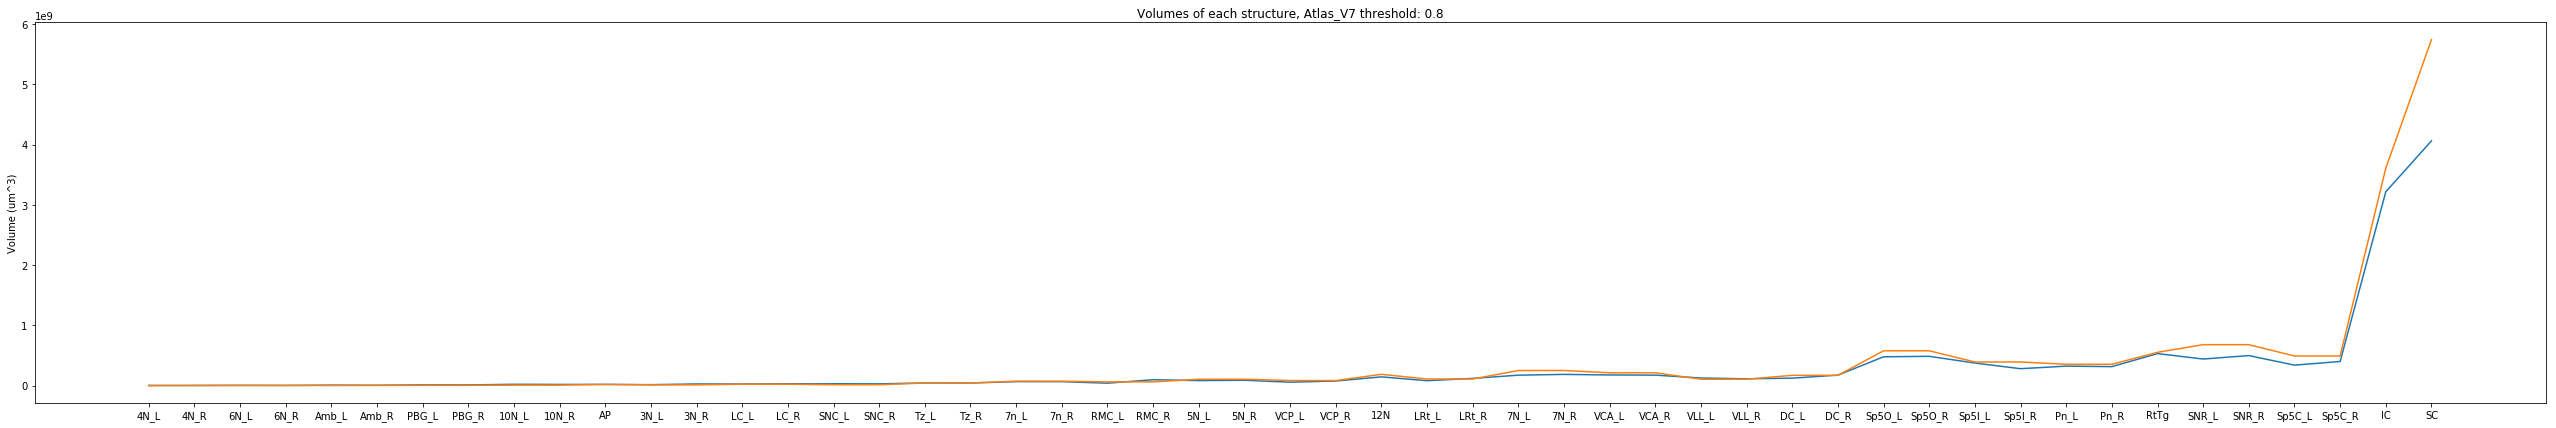

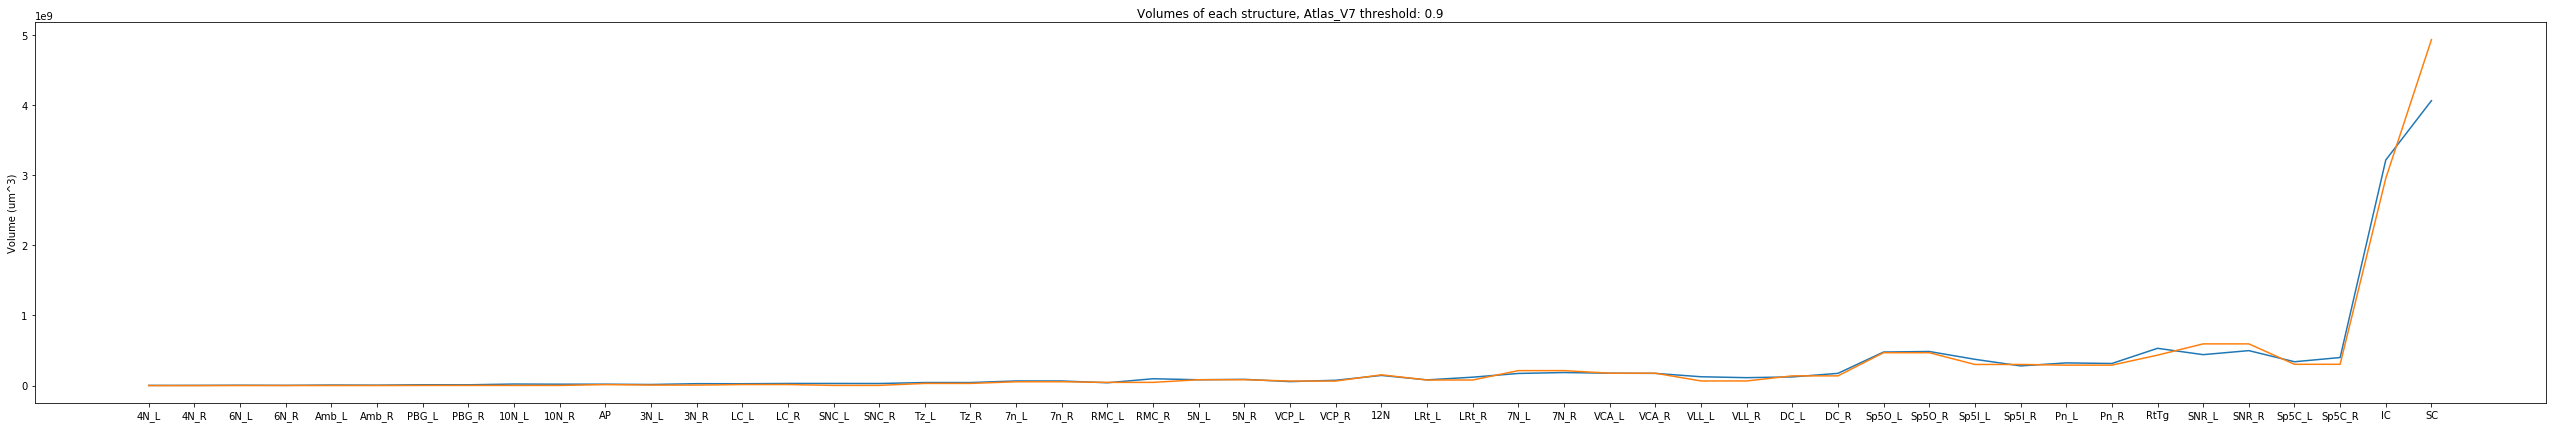

In [239]:
for threshold in threshold_list:
    plt.figure( figsize=(45, 7) )

    plt.plot( vols_indices, vols )
    plt.plot( vols_indices, atlas_v7_volumes[threshold] )

    # plt.xlabel( structuress_sided_sorted_by_size )
    plt.ylabel('Volume (um^3)')
    plt.xticks( np.arange(len(structures_sided_sorted_by_size)), structures_sided_sorted_by_size )
    plt.title('Volumes of each structure, Atlas_V7 threshold: '+str(threshold))
    plt.show()

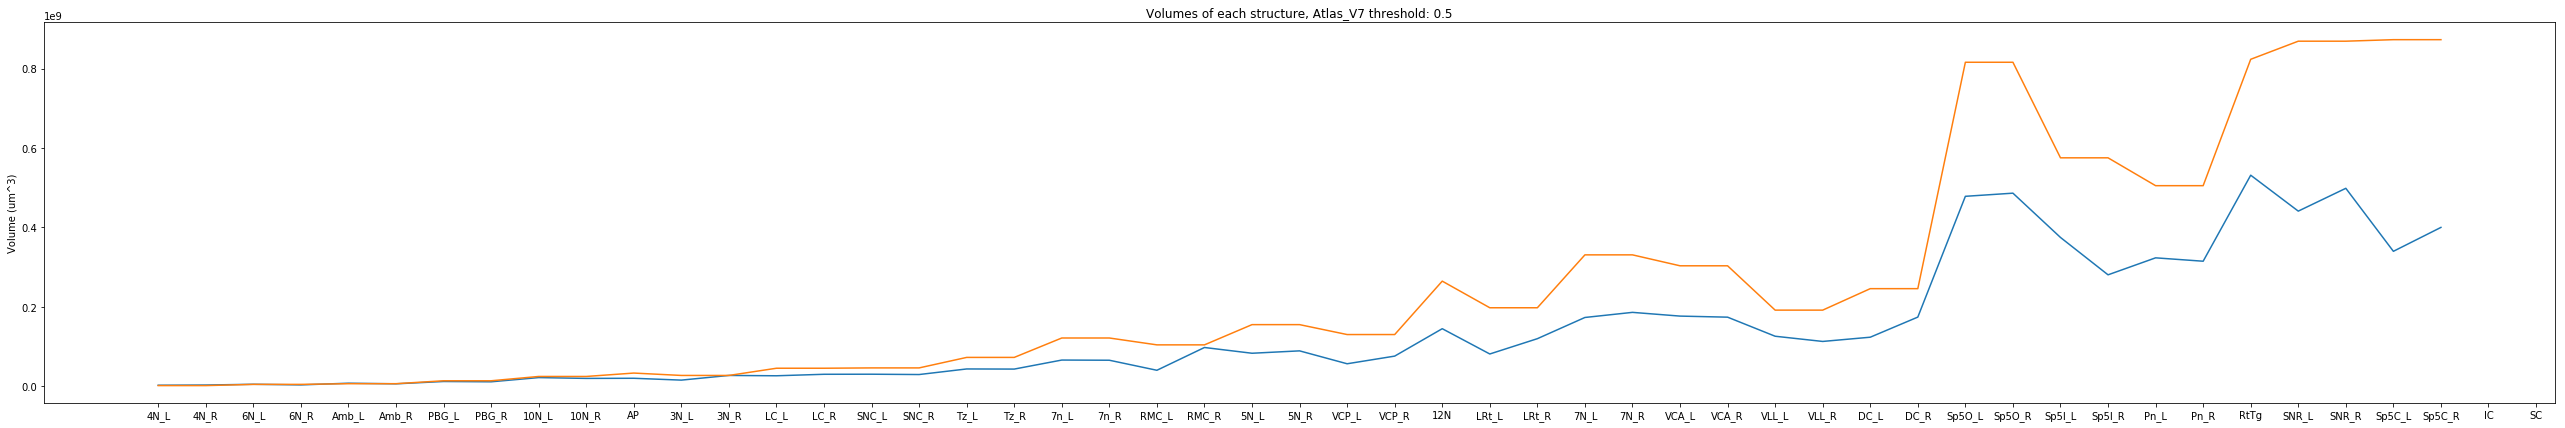

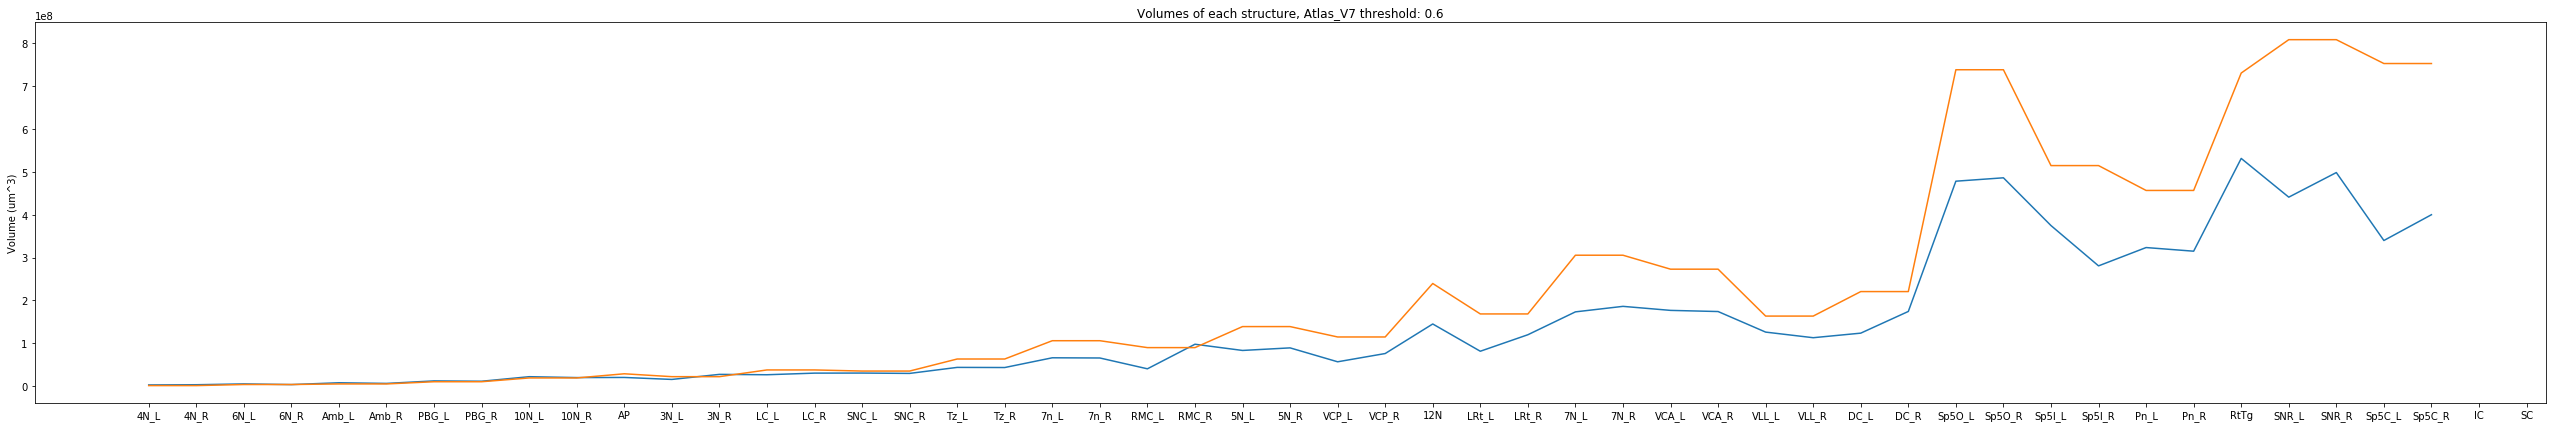

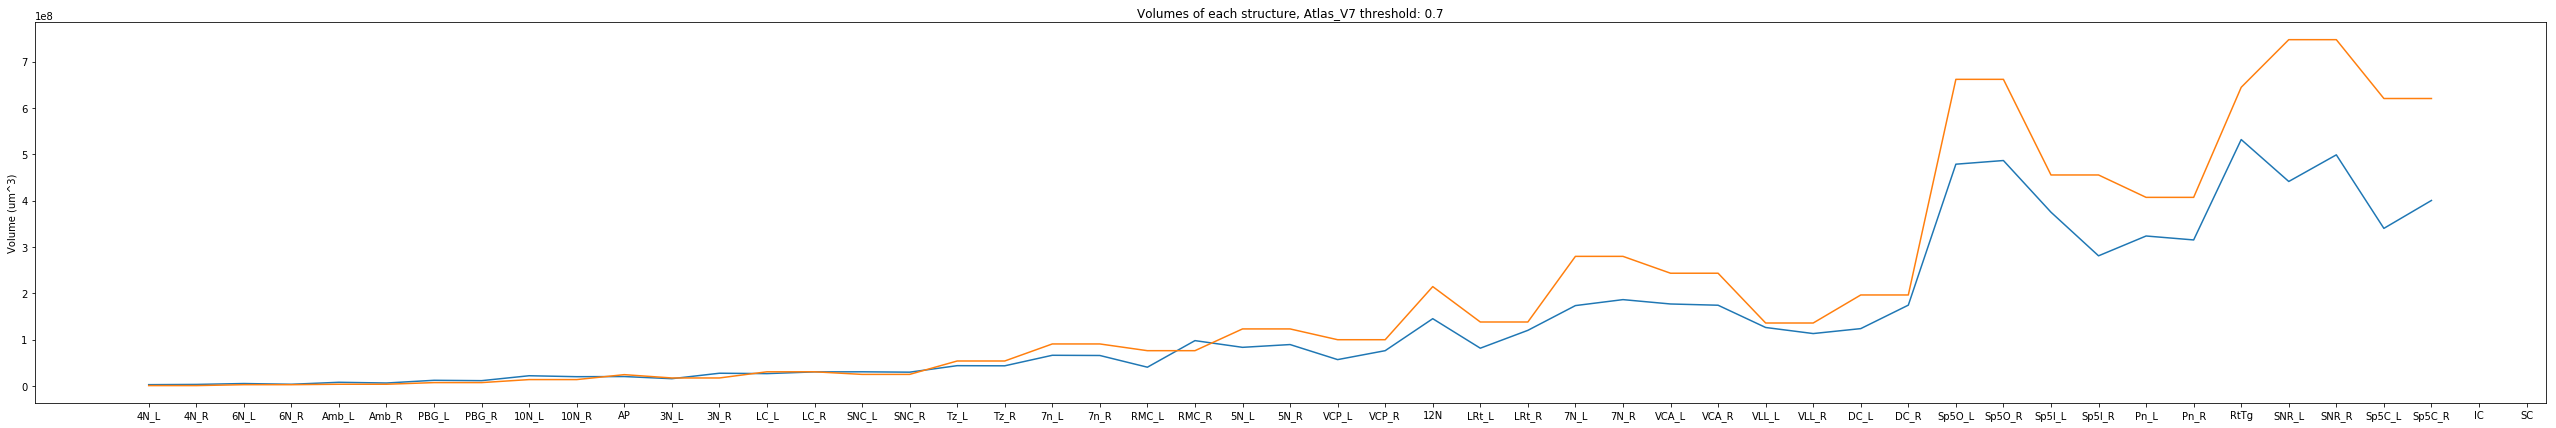

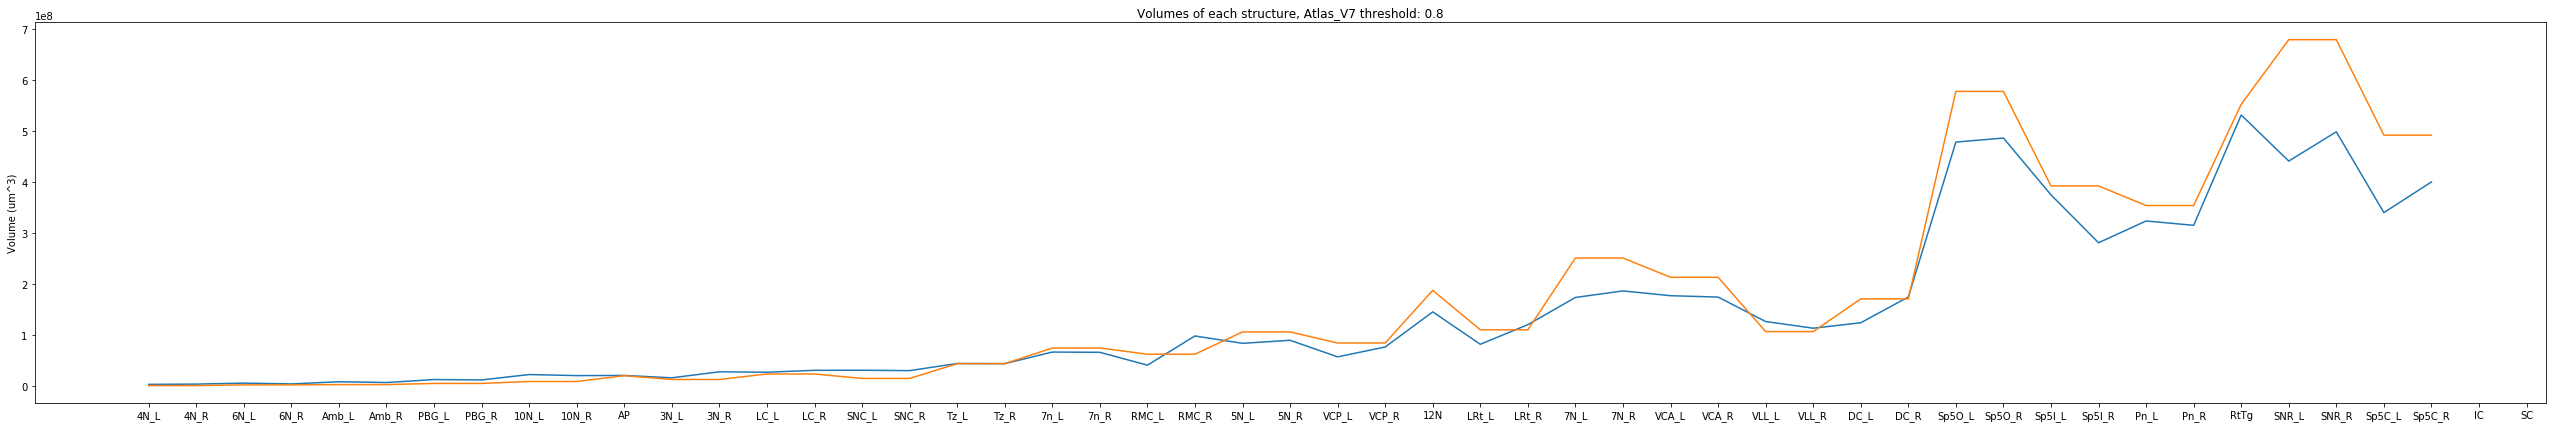

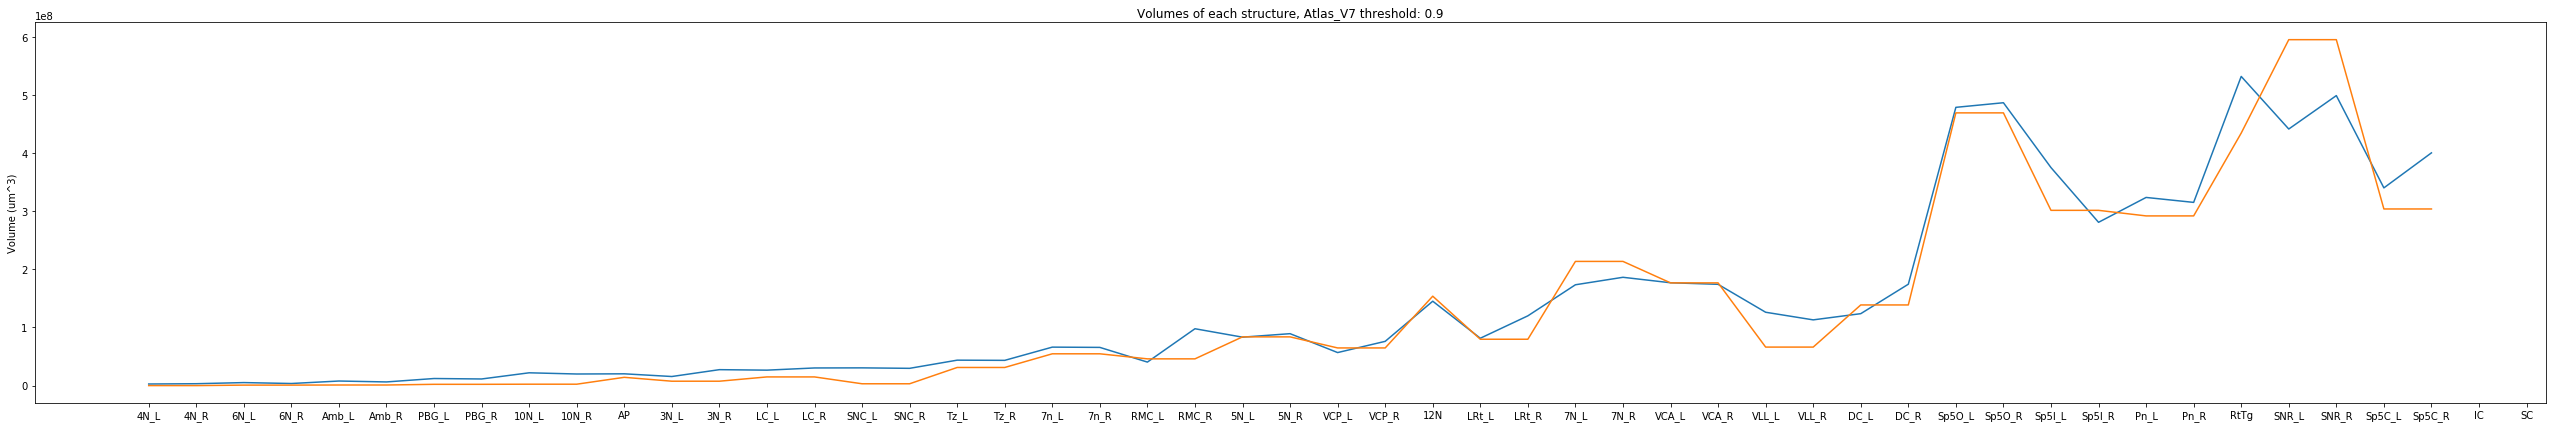

In [242]:
for threshold in threshold_list:
    plt.figure( figsize=(45, 7) )

    plt.plot( vols_indices[:-2], vols[:-2] )
    plt.plot( vols_indices[:-2], atlas_v7_volumes[threshold][:-2] )

    # plt.xlabel( structures_sided_sorted_by_size )
    plt.ylabel('Volume (um^3)')
    plt.xticks( np.arange(len(structures_sided_sorted_by_size)), structures_sided_sorted_by_size )
    plt.title('Volumes of each structure, Atlas_V7 threshold: '+str(threshold))
    plt.show()

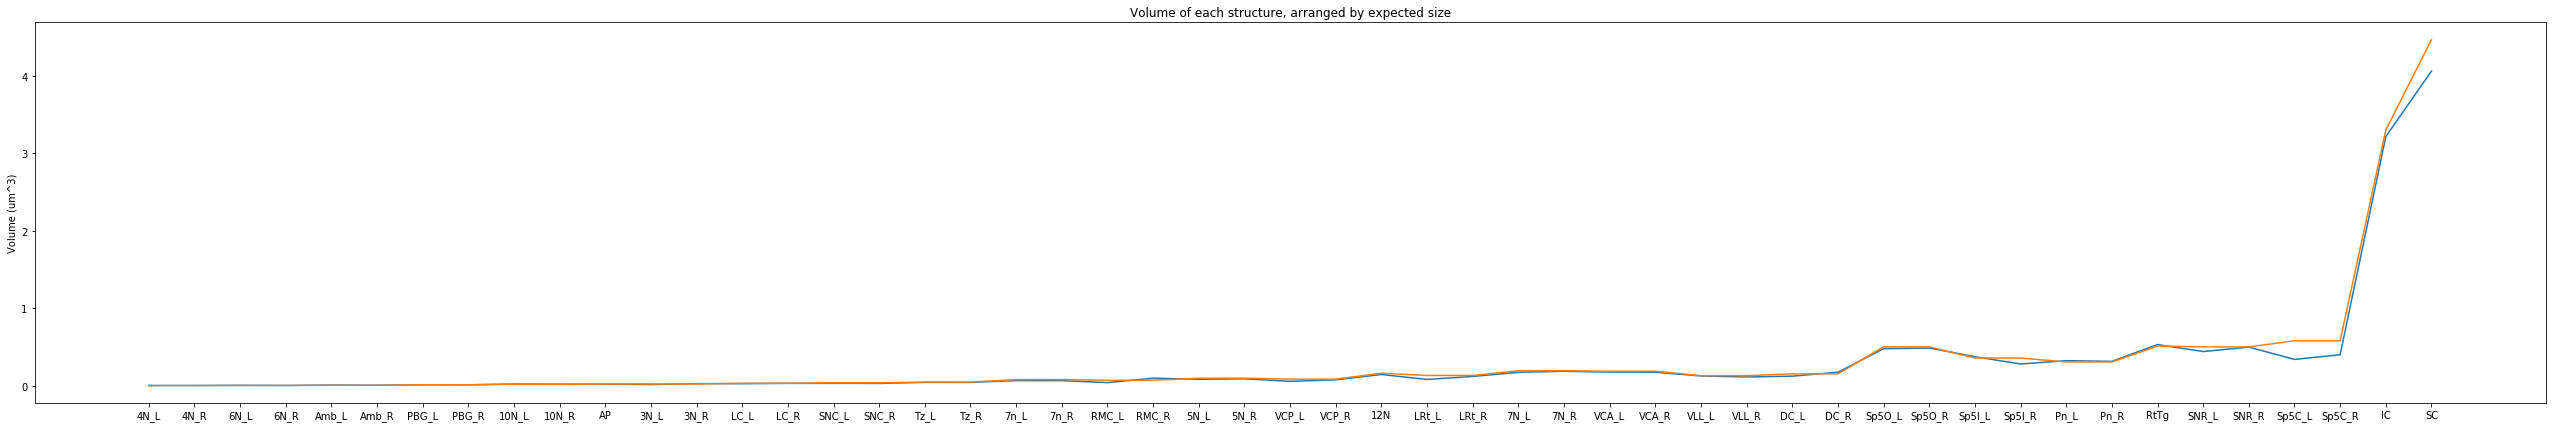

In [226]:
plt.figure( figsize=(45, 7) )

plt.plot( vols_indices, vols )
plt.plot( vols_indices, [v*0.002 for v in atlas_v7_volumes] )

# plt.xlabel( structures_sided_sorted_by_size )
plt.ylabel('Volume (um^3)')
plt.xticks( np.arange(len(structures_sided_sorted_by_size)), structures_sided_sorted_by_size )
plt.title('Volume of each structure, arranged by expected size')

plt.show()

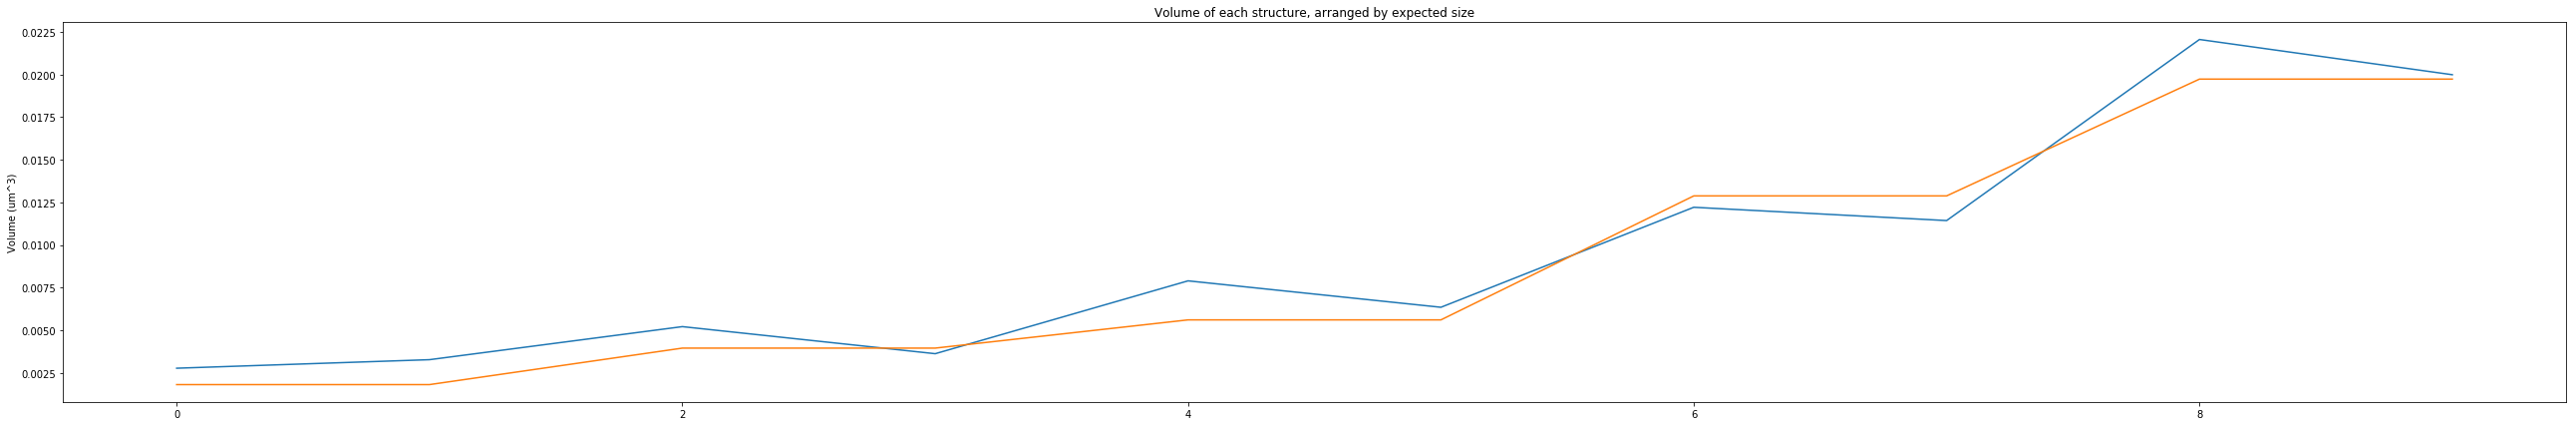

In [230]:
plt.figure( figsize=(45, 7) )

plt.plot( vols_indices[0:10], vols[0:10] )
plt.plot( vols_indices[0:10], [v*0.002 for v in atlas_v7_volumes[0:10]] )

# plt.xlabel( structures_sided_sorted_by_size )
plt.ylabel('Volume (um^3)')
# plt.xticks( np.arange(len(structures_sided_sorted_by_size)), structures_sided_sorted_by_size )
plt.title('Volume of each structure, arranged by expected size')

plt.show()